# 4호선 지하철 일일 수요량 예측_데이터결합완료

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Activation, BatchNormalization #
from keras.models import Sequential #
from keras.models import load_model, save_model #

from sklearn.preprocessing import StandardScaler, MinMaxScaler

print(tf.__version__)

2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 정리하기
- goal : 시위를 포함한 4호선 지하철 일일 수요량 예측? 
- y는 지하철 수요 
- x는 (강수량,기온), 공휴일, 요일, 시위 여부

## 날씨 데이터 전처리

In [ ]:
w = pd.read_csv("/content/drive/Shareddrives/ai/data/Seoul_weather.csv")
w

,region,date,temperature,rainfall,wind_speed,humidity,snowfall
0,서울,2021-09-01 07:00,19.3,0.0,3.3,94,0.0
1,서울,2021-09-01 08:00,19.6,0.0,3.3,92,0.0
2,서울,2021-09-01 09:00,20.1,0.0,3.5,90,0.0
3,서울,2021-09-02 07:00,20.8,0.0,2.5,78,0.0
4,서울,2021-09-02 08:00,21.4,0.0,3.1,74,0.0
...,...,...,...,...,...,...,...
1090,서울,2022-08-30 08:00,18.0,2.8,2.9,99,0.0
1091,서울,2022-08-30 09:00,18.2,2.3,2.3,99,0.0
1092,서울,2022-08-31 07:00,19.6,0.0,0.8,93,0.0
1093,서울,2022-08-31 08:00,19.9,0.0,1.7,92,0.0


In [ ]:
from datetime import datetime

# object -> datatime으로 변환
w['datetime'] = w['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M'))
w.head(2)

,region,date,temperature,rainfall,wind_speed,humidity,snowfall,datetime
0,서울,2021-09-01 07:00,19.3,0.0,3.3,94,0.0,2021-09-01 07:00:00
1,서울,2021-09-01 08:00,19.6,0.0,3.3,92,0.0,2021-09-01 08:00:00


In [ ]:
# data 원소들 추출해둠
w['year'] = w['datetime'].dt.year
w['month'] = w['datetime'].dt.month
w['day'] = w['datetime'].dt.day
w['d_name'] = w['datetime'].dt.day_name()

w.head(2)

,region,date,temperature,rainfall,wind_speed,humidity,snowfall,datetime,year,month,day,d_name
0,서울,2021-09-01 07:00,19.3,0.0,3.3,94,0.0,2021-09-01 07:00:00,2021,9,1,Wednesday
1,서울,2021-09-01 08:00,19.6,0.0,3.3,92,0.0,2021-09-01 08:00:00,2021,9,1,Wednesday


In [ ]:
w.info() #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   region       1095 non-null   object        
 1   date         1095 non-null   object        
 2   temperature  1095 non-null   float64       
 3   rainfall     1095 non-null   float64       
 4   wind_speed   1095 non-null   float64       
 5   humidity     1095 non-null   int64         
 6   snowfall     1095 non-null   float64       
 7   datetime     1095 non-null   datetime64[ns]
 8   year         1095 non-null   int64         
 9   month        1095 non-null   int64         
 10  day          1095 non-null   int64         
 11  d_name       1095 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 102.8+ KB


In [ ]:
# 년,월,일별로 평균냄

w['tem_m'] = w.groupby(['year','month','day'])['temperature'].transform('mean')
w['rain_m'] = w.groupby(['year','month','day'])['rainfall'].transform('mean')
w['wind_m'] = w.groupby(['year','month','day'])['wind_speed'].transform('mean')
w['humid_m'] = w.groupby(['year','month','day'])['humidity'].transform('mean')
w.head(4)

,region,date,temperature,rainfall,wind_speed,humidity,snowfall,datetime,year,month,day,d_name,tem_m,rain_m,wind_m,humid_m
0,서울,2021-09-01 07:00,19.3,0.0,3.3,94,0.0,2021-09-01 07:00:00,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.000000
1,서울,2021-09-01 08:00,19.6,0.0,3.3,92,0.0,2021-09-01 08:00:00,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.000000
2,서울,2021-09-01 09:00,20.1,0.0,3.5,90,0.0,2021-09-01 09:00:00,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.000000
3,서울,2021-09-02 07:00,20.8,0.0,2.5,78,0.0,2021-09-02 07:00:00,2021,9,2,Thursday,21.633333,0.0,2.733333,73.333333


In [ ]:
np.set_printoptions(precision=3, suppress=True)

df_w = w[['datetime','year','month', 'day', 'd_name','tem_m','rain_m','wind_m','humid_m']]
df_w = df_w.drop_duplicates(['year','month', 'day'])

df_w['date'] = pd.to_datetime(df_w['datetime']).dt.date
df_w = df_w.drop(['datetime'], axis = 1)
df_w['date']=df_w['date'].astype('datetime64')
df_w

,year,month,day,d_name,tem_m,rain_m,wind_m,humid_m,date
0,2021,9,1,Wednesday,19.666667,0.000000,3.366667,92.000000,2021-09-01
3,2021,9,2,Thursday,21.633333,0.000000,2.733333,73.333333,2021-09-02
6,2021,9,3,Friday,22.400000,0.000000,2.533333,73.333333,2021-09-03
9,2021,9,4,Saturday,20.633333,0.000000,2.566667,66.666667,2021-09-04
12,2021,9,5,Sunday,20.966667,0.000000,2.800000,68.333333,2021-09-05
...,...,...,...,...,...,...,...,...,...
1080,2022,8,27,Saturday,18.500000,0.000000,2.133333,75.000000,2022-08-27
1083,2022,8,28,Sunday,18.900000,0.000000,1.866667,72.333333,2022-08-28
1086,2022,8,29,Monday,19.866667,0.366667,2.500000,84.333333,2022-08-29
1089,2022,8,30,Tuesday,18.066667,2.100000,2.766667,98.666667,2022-08-30


## 공휴일(holiday)

In [ ]:
h = pd.read_csv("/content/drive/Shareddrives/ai/data/국가공휴일_2023년까지.csv", encoding='CP949')
h = h.reset_index(drop=True)

cols = ['년', '월', '일']

for col in cols:
  h[col] = h[col].astype(str)

h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   순서      105 non-null    int64 
 1   년       105 non-null    object
 2   월       105 non-null    object
 3   일       105 non-null    object
 4   설명      105 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.2+ KB


In [ ]:
h['date'] = h['년'] + '-' + h['월']+ '-' + h['월']
h['date'] = pd.to_datetime(h['date'])
h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   순서      105 non-null    int64         
 1   년       105 non-null    object        
 2   월       105 non-null    object        
 3   일       105 non-null    object        
 4   설명      105 non-null    object        
 5   date    105 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 5.0+ KB


In [ ]:
data = pd.merge(df_w, h,
                how='left',
                on='date')

In [ ]:
data = data.drop(['순서','년','월','일'],axis =1)

In [ ]:
data[data['설명']=='광복절']

,year,month,day,d_name,tem_m,rain_m,wind_m,humid_m,date,설명
351,2022,8,8,Monday,27.266667,0.9,3.9,90.333333,2022-08-08,광복절


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 0 to 374
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     375 non-null    int64         
 1   month    375 non-null    int64         
 2   day      375 non-null    int64         
 3   d_name   375 non-null    object        
 4   tem_m    375 non-null    float64       
 5   rain_m   375 non-null    float64       
 6   wind_m   375 non-null    float64       
 7   humid_m  375 non-null    float64       
 8   date     375 non-null    datetime64[ns]
 9   설명       19 non-null     object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 32.2+ KB


## 주말 / 평일 

In [ ]:
data['d_name'].unique()

array(['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday',
       'Tuesday'], dtype=object)

In [ ]:
'''
yoil=[]
for i in range(len(data)) : 
  if data.iloc[i,3]=='Monday' : yoil.append(0)
  if data.iloc[i,3]=='Tuesday' : yoil.append(1)
  if data.iloc[i,3]=='Wednesday' : yoil.append(2)
  if data.iloc[i,3]=='Thursday' : yoil.append(3)
  if data.iloc[i,3]=='Friday' : yoil.append(4)
  if data.iloc[i,3]=='Saturday' : yoil.append(5)
  if data.iloc[i,3]=='Sunday' : yoil.append(6)
data['요일']=yoil
data.head()
'''

"\nyoil=[]\nfor i in range(len(data)) : \n  if data.iloc[i,3]=='Monday' : yoil.append(0)\n  if data.iloc[i,3]=='Tuesday' : yoil.append(1)\n  if data.iloc[i,3]=='Wednesday' : yoil.append(2)\n  if data.iloc[i,3]=='Thursday' : yoil.append(3)\n  if data.iloc[i,3]=='Friday' : yoil.append(4)\n  if data.iloc[i,3]=='Saturday' : yoil.append(5)\n  if data.iloc[i,3]=='Sunday' : yoil.append(6)\ndata['요일']=yoil\ndata.head()\n"

In [ ]:
data['dayofweek'] = data['date'].dt.dayofweek
data

,year,month,day,d_name,tem_m,rain_m,wind_m,humid_m,date,설명,dayofweek
0,2021,9,1,Wednesday,19.666667,0.000000,3.366667,92.000000,2021-09-01,NaN,2
1,2021,9,2,Thursday,21.633333,0.000000,2.733333,73.333333,2021-09-02,NaN,3
2,2021,9,3,Friday,22.400000,0.000000,2.533333,73.333333,2021-09-03,NaN,4
3,2021,9,4,Saturday,20.633333,0.000000,2.566667,66.666667,2021-09-04,NaN,5
4,2021,9,5,Sunday,20.966667,0.000000,2.800000,68.333333,2021-09-05,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...
370,2022,8,27,Saturday,18.500000,0.000000,2.133333,75.000000,2022-08-27,NaN,5
371,2022,8,28,Sunday,18.900000,0.000000,1.866667,72.333333,2022-08-28,NaN,6
372,2022,8,29,Monday,19.866667,0.366667,2.500000,84.333333,2022-08-29,NaN,0
373,2022,8,30,Tuesday,18.066667,2.100000,2.766667,98.666667,2022-08-30,NaN,1


In [ ]:
working = []

for i in range(len(data)) : 
  if data.loc[i,'dayofweek'] < 5: 
    working.append(1) 
  else: 
    working .append(0)

data['working'] = working 
data.head()

,year,month,day,d_name,tem_m,rain_m,wind_m,humid_m,date,설명,dayofweek,working
0,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.000000,2021-09-01,NaN,2,1
1,2021,9,2,Thursday,21.633333,0.0,2.733333,73.333333,2021-09-02,NaN,3,1
2,2021,9,3,Friday,22.400000,0.0,2.533333,73.333333,2021-09-03,NaN,4,1
3,2021,9,4,Saturday,20.633333,0.0,2.566667,66.666667,2021-09-04,NaN,5,0
4,2021,9,5,Sunday,20.966667,0.0,2.800000,68.333333,2021-09-05,NaN,6,0


## 승하차 정리

In [ ]:
t = pd.read_csv('/content/drive/Shareddrives/ai/data/승하차 최종..csv', encoding='CP949')
t = t.drop(['구분','호선'], axis = 1).rename(columns={'07시-10시': 'people', '날짜':'date'})
t

,date,역명,people
0,2021-09-01,당고개,5330
1,2021-09-01,상계,8016
2,2021-09-01,노원,5618
3,2021-09-01,창동,8402
4,2021-09-01,쌍문,12586
...,...,...,...
9485,2022-08-31,이촌(국립중앙박물관),1689
9486,2022-08-31,동작(현충원),314
9487,2022-08-31,총신대입구(이수),5922
9488,2022-08-31,사당,9275


In [ ]:
t['date'] = t['date'].astype('datetime64')

In [ ]:
data_t= pd.merge(data,t,
                 how='left',
                 on='date')

In [ ]:
# 공휴일 변환 

holiday = []

for i in range(len(data_t)) : 
  if pd.isna(data_t.loc[i,'설명']): 
    holiday.append(0) 
  else: 
    holiday.append(1)

data_t['holiday'] = holiday
data_t['holiday'].sum()

494

- 총 1년 데이터 중 공휴일이 494번 입력

In [ ]:
data_t

,year,month,day,d_name,tem_m,rain_m,wind_m,humid_m,date,설명,dayofweek,working,역명,people,holiday
0,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,당고개,5330,0
1,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,상계,8016,0
2,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,노원,5618,0
3,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,창동,8402,0
4,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,쌍문,12586,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9745,2022,8,31,Wednesday,19.933333,0.0,1.366667,92.0,2022-08-31,NaN,2,1,이촌(국립중앙박물관),1689,0
9746,2022,8,31,Wednesday,19.933333,0.0,1.366667,92.0,2022-08-31,NaN,2,1,동작(현충원),314,0
9747,2022,8,31,Wednesday,19.933333,0.0,1.366667,92.0,2022-08-31,NaN,2,1,총신대입구(이수),5922,0
9748,2022,8,31,Wednesday,19.933333,0.0,1.366667,92.0,2022-08-31,NaN,2,1,사당,9275,0


## 시위데이터

In [ ]:
si = pd.read_csv('/content/drive/Shareddrives/ai/data/2021.12-2022.08 시위일자 최종.csv', encoding='CP949')
si = si[['시위일자', '호선', '역명']]
si= si.drop('호선', axis = 1).rename(columns={'시위일자':'date'})
si['date'] = si['date'].astype('datetime64')
si['event'] = 1
si

,date,역명,event
0,2021-12-09,혜화,1
1,2021-12-10,혜화,1
2,2021-12-13,혜화,1
3,2021-12-29,성신여대입구(돈암),1
4,2022-01-21,미아사거리,1
...,...,...,...
535,2022-08-31,명동,1
536,2022-08-31,충무로,1
537,2022-08-31,동대문역사문화공원(DDP),1
538,2022-08-31,동대문,1


In [ ]:
data = pd.merge(data_t,si,
                how='left',
                on=['date','역명'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9769 entries, 0 to 9768
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   year       9769 non-null   int64         
 1   month      9769 non-null   int64         
 2   day        9769 non-null   int64         
 3   d_name     9769 non-null   object        
 4   tem_m      9769 non-null   float64       
 5   rain_m     9769 non-null   float64       
 6   wind_m     9769 non-null   float64       
 7   humid_m    9769 non-null   float64       
 8   date       9769 non-null   datetime64[ns]
 9   설명         498 non-null    object        
 10  dayofweek  9769 non-null   int64         
 11  working    9769 non-null   int64         
 12  역명         9769 non-null   object        
 13  people     9769 non-null   int64         
 14  holiday    9769 non-null   int64         
 15  event      521 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(7)

- event 숫자가 540, 521로 차이나는 것을 보아 역명이 같지 않는 것이 있는 듯

In [ ]:
data[data['event']==1].head()

,year,month,day,d_name,tem_m,rain_m,wind_m,humid_m,date,설명,dayofweek,working,역명,people,holiday,event
2715,2021,12,9,Thursday,3.366667,0.0,2.300000,78.666667,2021-12-09,NaN,3,1,혜화,2349,0,1.0
2741,2021,12,10,Friday,7.233333,0.0,2.366667,69.000000,2021-12-10,NaN,4,1,혜화,2355,0,1.0
2819,2021,12,13,Monday,-5.533333,0.0,2.333333,52.000000,2021-12-13,NaN,0,1,혜화,2486,0,1.0
3233,2021,12,29,Wednesday,-1.366667,0.0,1.700000,84.666667,2021-12-29,NaN,2,1,성신여대입구(돈암),4975,0,1.0
3855,2022,1,21,Friday,-8.033333,0.0,1.866667,77.000000,2022-01-21,NaN,4,1,미아사거리,9770,0,1.0


In [ ]:
data['event']=data['event'].fillna(0)
data

,year,month,day,d_name,tem_m,rain_m,wind_m,humid_m,date,설명,dayofweek,working,역명,people,holiday,event
0,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,당고개,5330,0,0.0
1,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,상계,8016,0,0.0
2,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,노원,5618,0,0.0
3,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,창동,8402,0,0.0
4,2021,9,1,Wednesday,19.666667,0.0,3.366667,92.0,2021-09-01,NaN,2,1,쌍문,12586,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9764,2022,8,31,Wednesday,19.933333,0.0,1.366667,92.0,2022-08-31,NaN,2,1,이촌(국립중앙박물관),1689,0,0.0
9765,2022,8,31,Wednesday,19.933333,0.0,1.366667,92.0,2022-08-31,NaN,2,1,동작(현충원),314,0,0.0
9766,2022,8,31,Wednesday,19.933333,0.0,1.366667,92.0,2022-08-31,NaN,2,1,총신대입구(이수),5922,0,0.0
9767,2022,8,31,Wednesday,19.933333,0.0,1.366667,92.0,2022-08-31,NaN,2,1,사당,9275,0,0.0


In [ ]:
'''
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46384 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_

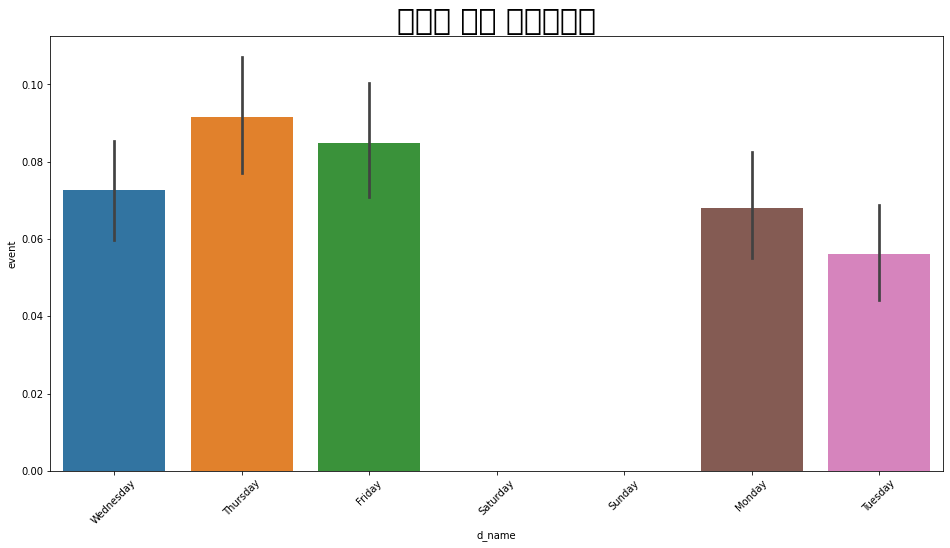

In [ ]:
plt.figure(figsize = (16,8))
sns.barplot(x = "d_name", y = "event", data = data)
plt.title("요일에 따른 시위데이터", fontsize = 30)
plt.xticks(rotation=45)
plt.show()

## 코로나데이터

In [ ]:
# pd.read_csv('')

## 최종데이터 결합 완료


# 데이터 **전처리**

In [ ]:
dataset = data.drop(['year','month', 'day', 'd_name','date','설명','dayofweek'], axis = 1)
dataset

,tem_m,rain_m,wind_m,humid_m,working,역명,people,holiday,event
0,19.666667,0.0,3.366667,92.0,1,당고개,5330,0,0.0
1,19.666667,0.0,3.366667,92.0,1,상계,8016,0,0.0
2,19.666667,0.0,3.366667,92.0,1,노원,5618,0,0.0
3,19.666667,0.0,3.366667,92.0,1,창동,8402,0,0.0
4,19.666667,0.0,3.366667,92.0,1,쌍문,12586,0,0.0
...,...,...,...,...,...,...,...,...,...
9764,19.933333,0.0,1.366667,92.0,1,이촌(국립중앙박물관),1689,0,0.0
9765,19.933333,0.0,1.366667,92.0,1,동작(현충원),314,0,0.0
9766,19.933333,0.0,1.366667,92.0,1,총신대입구(이수),5922,0,0.0
9767,19.933333,0.0,1.366667,92.0,1,사당,9275,0,0.0


In [ ]:
dataset.isnull().sum()

tem_m      0
rain_m     0
wind_m     0
humid_m    0
working    0
역명         0
people     0
holiday    0
event      0
dtype: int64

In [ ]:
# dataset = pd.get_dummies(dataset, columns=['역명'])

# EDA

## 시간에 따른 예측값 (지하철 수요)

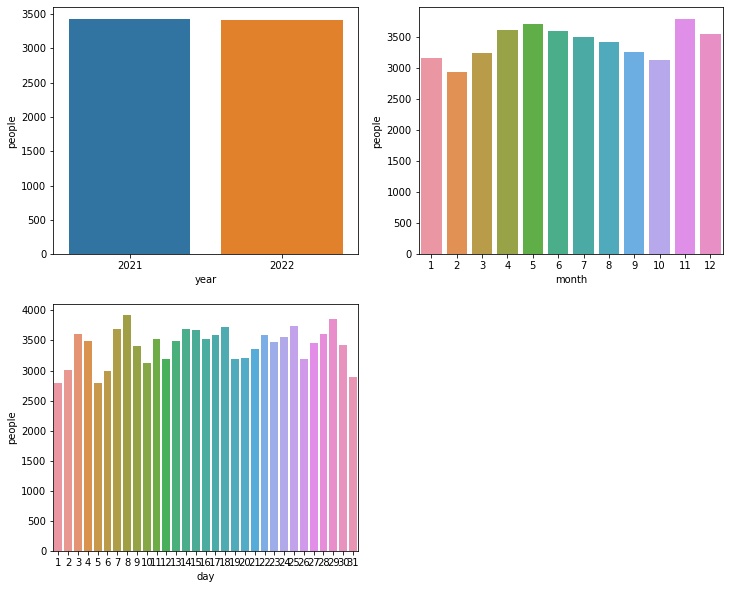

In [ ]:
#년도와 people
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='year',y='people',data=data.groupby('year')['people'].mean().reset_index())

#month와 people
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='month',y='people',data=data.groupby('month')['people'].mean().reset_index())

#day와 people
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='day',y='people',data=data.groupby('day')['people'].mean().reset_index())


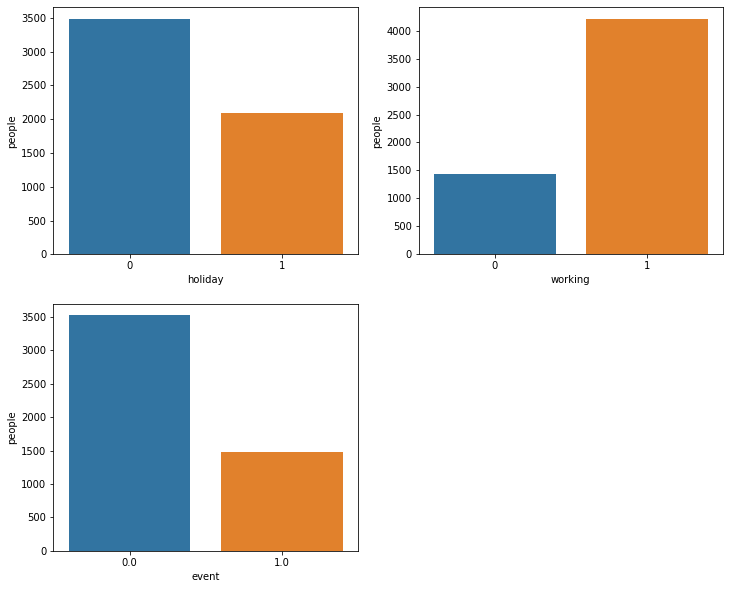

In [ ]:
fig = plt.figure(figsize=[12,10])

#휴일 여부와 people
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='holiday',y='people',data=data.groupby('holiday')['people'].mean().reset_index())

#작업일 여부와 people
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='working',y='people',data=data.groupby('working')['people'].mean().reset_index())

#시위 여부와 people
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='event',y='people',data=data.groupby('event')['people'].mean().reset_index())


In [ ]:
X = dataset.copy() 
Y = X.pop('people')

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9769 entries, 0 to 9768
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tem_m    9769 non-null   float64
 1   rain_m   9769 non-null   float64
 2   wind_m   9769 non-null   float64
 3   humid_m  9769 non-null   float64
 4   working  9769 non-null   int64  
 5   역명       9769 non-null   object 
 6   holiday  9769 non-null   int64  
 7   event    9769 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 944.9+ KB


In [ ]:
numeric_feature = ['tem_m','rain_m','wind_m','humid_m']
categorical_feature = ['역명','working', 'holiday', 'event']


print("수치형 데이터는 다음과 같습니다. \n", list(numeric_feature))
print("카테고리형 데이터는 다음과 같습니다. \n", list(categorical_feature))

수치형 데이터는 다음과 같습니다. 
 ['tem_m', 'rain_m', 'wind_m', 'humid_m']
카테고리형 데이터는 다음과 같습니다. 
 ['역명', 'working', 'holiday', 'event']


## target과 수치형 feature의 관계


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

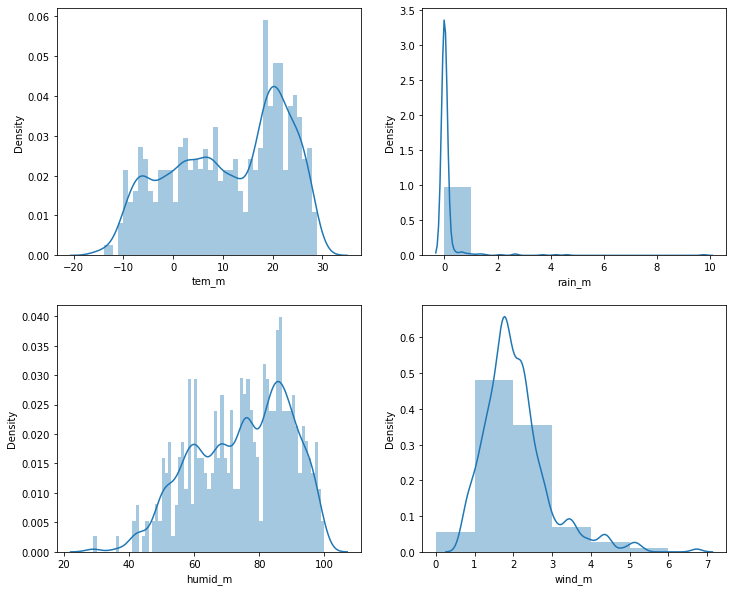

In [ ]:
# 온도 분포
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.distplot(dataset.tem_m,bins=range(dataset.tem_m.min().astype('int'),dataset.tem_m.max().astype('int')+1))

# 강수량 분포
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.distplot(dataset.rain_m,bins=range(dataset.rain_m.min().astype('int'),dataset.rain_m.max().astype('int')+1))

#습도와 분포
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.distplot(dataset.humid_m,bins=range(dataset.humid_m.min().astype('int'),dataset.humid_m.max().astype('int')+1))

#바람속도와 분포
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.distplot(dataset.wind_m,bins=range(dataset.wind_m.min().astype('int'),dataset.wind_m.max().astype('int')+1))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


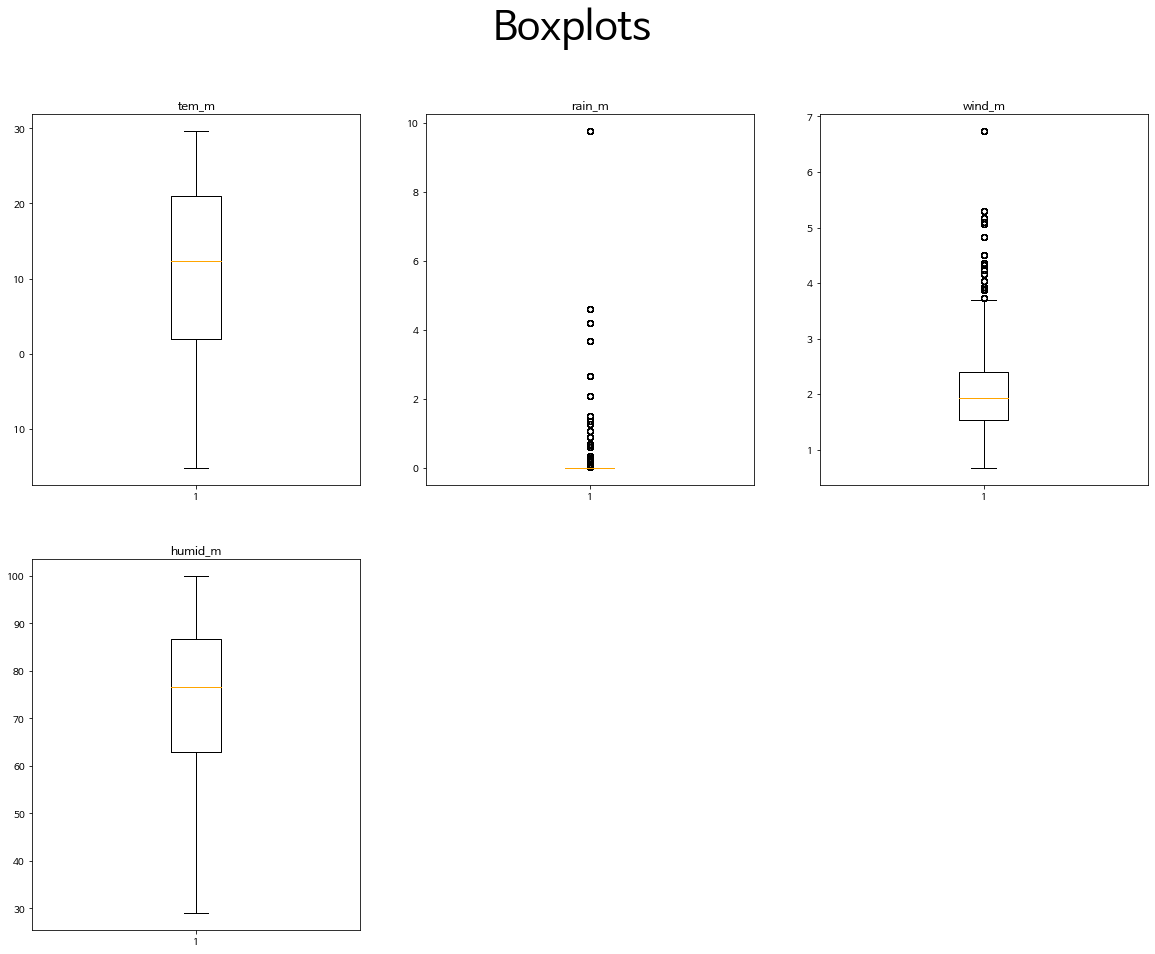

In [ ]:
# 수치형 데이터 시각화

feature = numeric_feature

# Boxplot 
plt.figure(figsize=(20,15))
plt.suptitle("Boxplots", fontsize=40)

for i in range(len(feature)):
    plt.subplot(2,3,i+1)
    plt.title(feature[i])
    plt.boxplot(X[feature[i]])
plt.show()

## 각각의 컬럼들 간의 상관계수를 heatmap을 통해 시각화

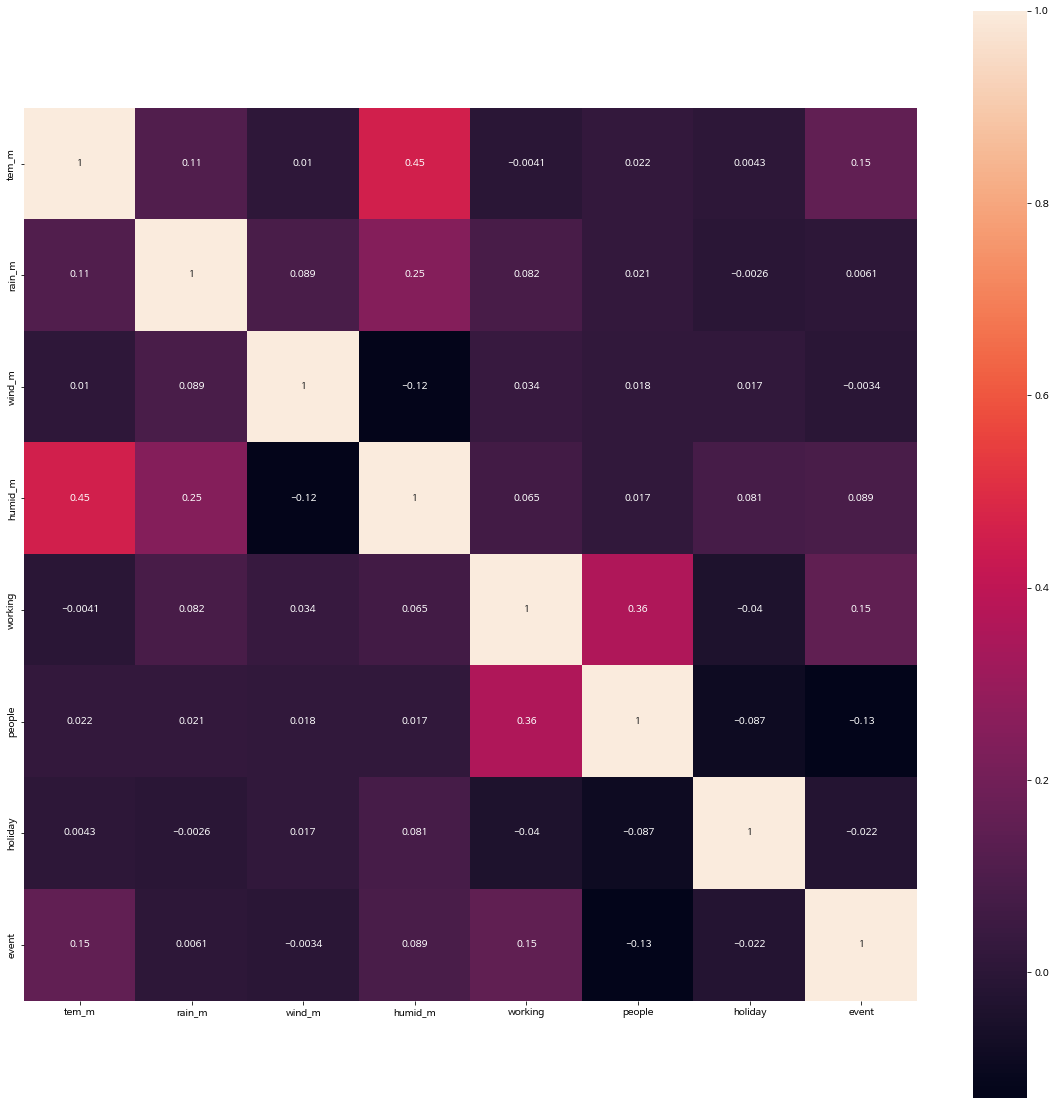

In [ ]:
fig = plt.figure(figsize=[20,20])
ax = sns.heatmap(dataset.corr(),annot=True,square=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


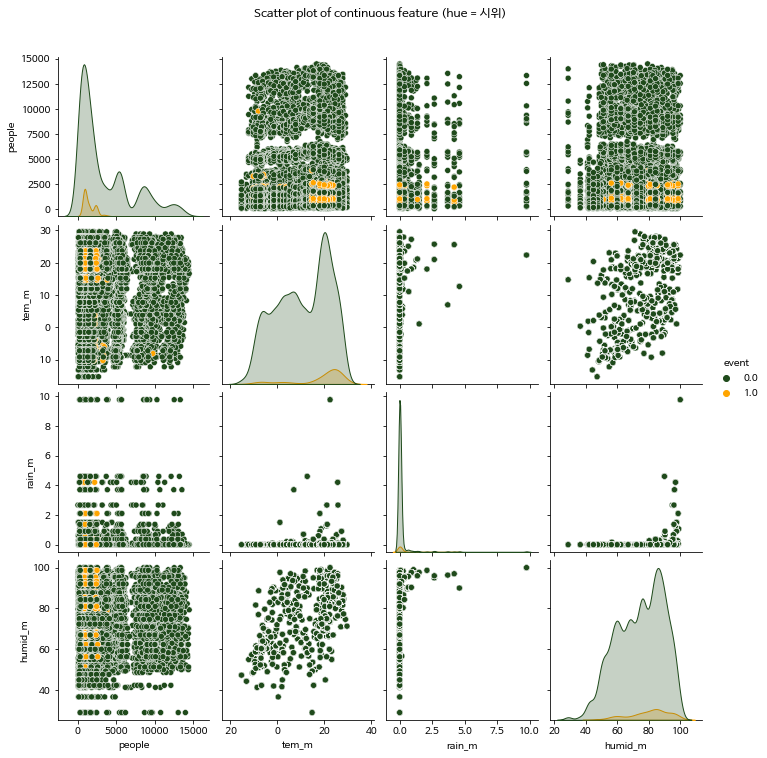

In [ ]:
## sns.pairplot(dataset[['people', 'tem_m', 'rain_m', 'humid_m']], diag_kind='kde')

# draw pairplot with hue = 시위
sns.set_palette(['#1f4a1b','orange','#bbff33','yellow'])
splot = sns.pairplot(data=dataset, x_vars=['people', 'tem_m', 'rain_m', 'humid_m'],
                     y_vars=['people', 'tem_m', 'rain_m', 'humid_m'], hue='event')
splot.fig.suptitle('Scatter plot of continuous feature (hue = 시위)', y=1.05)
plt.show()

In [ ]:
# target과 수치형 feature의 관계

feature = numeric_feature
people = 'people'

plt.figure(figsize=(20,15))
plt.suptitle("Scatter Plot", fontsize=40)


for i in range(len(feature[:-1])):
    plt.subplot(2,3,i+1)
    plt.xlabel(feature[i])
    plt.ylabel(people)
    corr_score = dataset[[feature[i], people]].corr().iloc[0,1].round(2)
    c = 'red' if corr_score > 0 else 'blue'
    plt.scatter(dataset[feature[i]], dataset[people], color=c, label=f"corr = {corr_score}")
    plt.legend(fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


NameError: ignored

## target과 카테고리형 feature의 관계

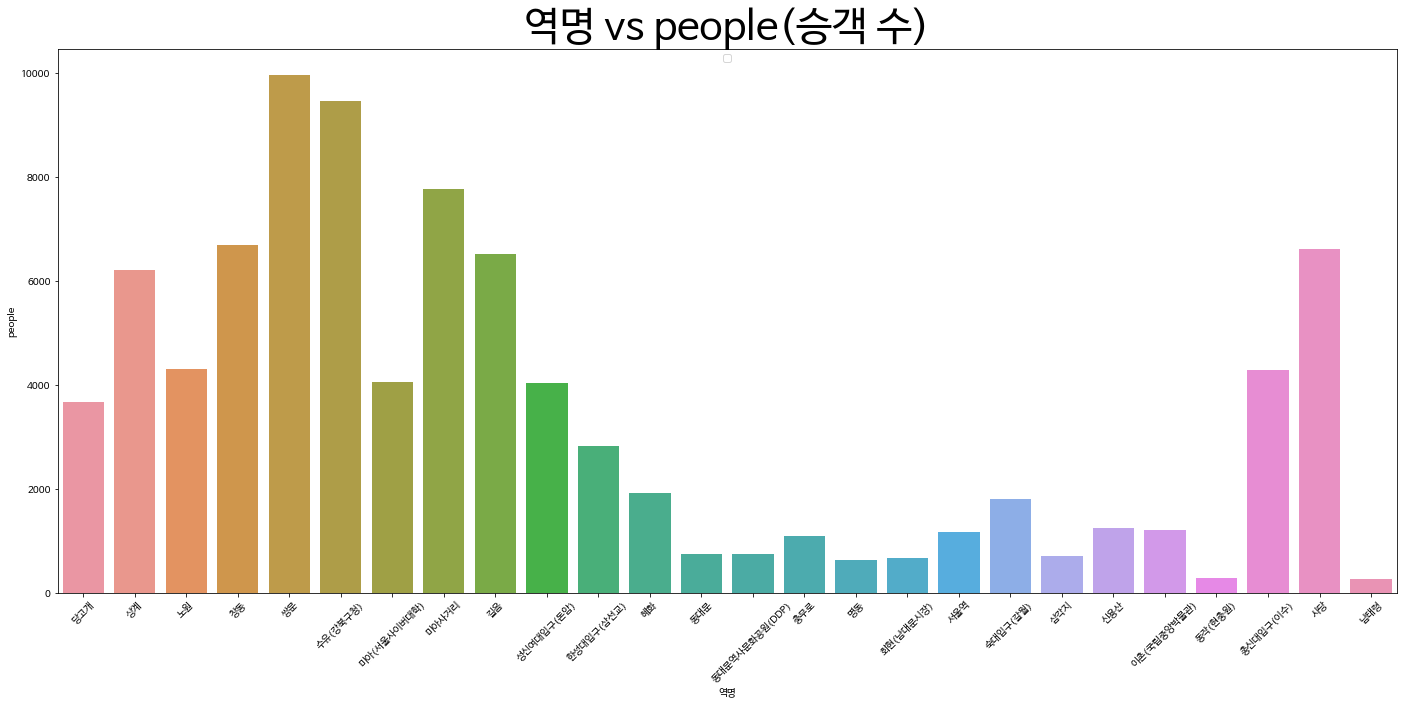

In [ ]:
plt.figure(figsize = (24,10))
sns.barplot(x = "역명", y = "people", data = train, ci = None)
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5,1))
plt.title("역명 vs people(승객 수)", fontsize = 40)
plt.xticks(rotation=45)
plt.show()

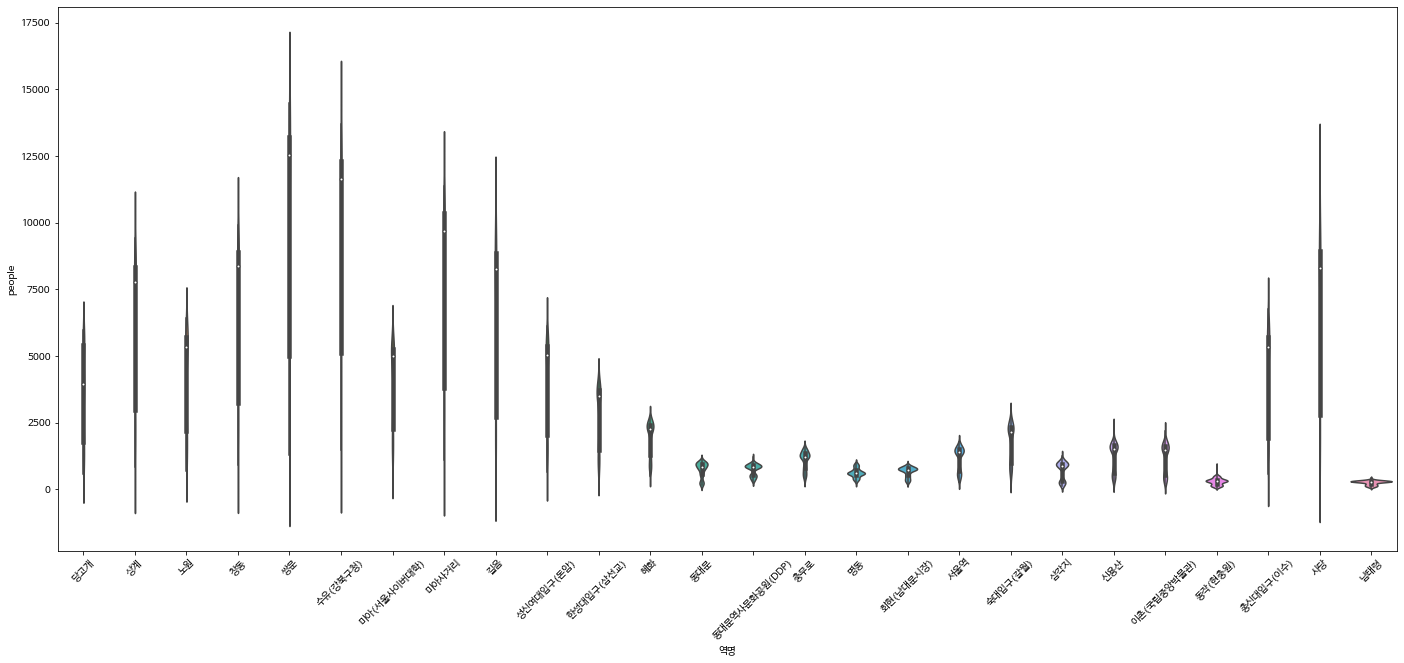

In [ ]:
plt.figure(figsize=(24,10))
plt.xlabel(feature[0])
plt.ylabel(people)
sns.violinplot(x = "역명", y = "people", data = train)
plt.xticks(rotation=45)
plt.show()

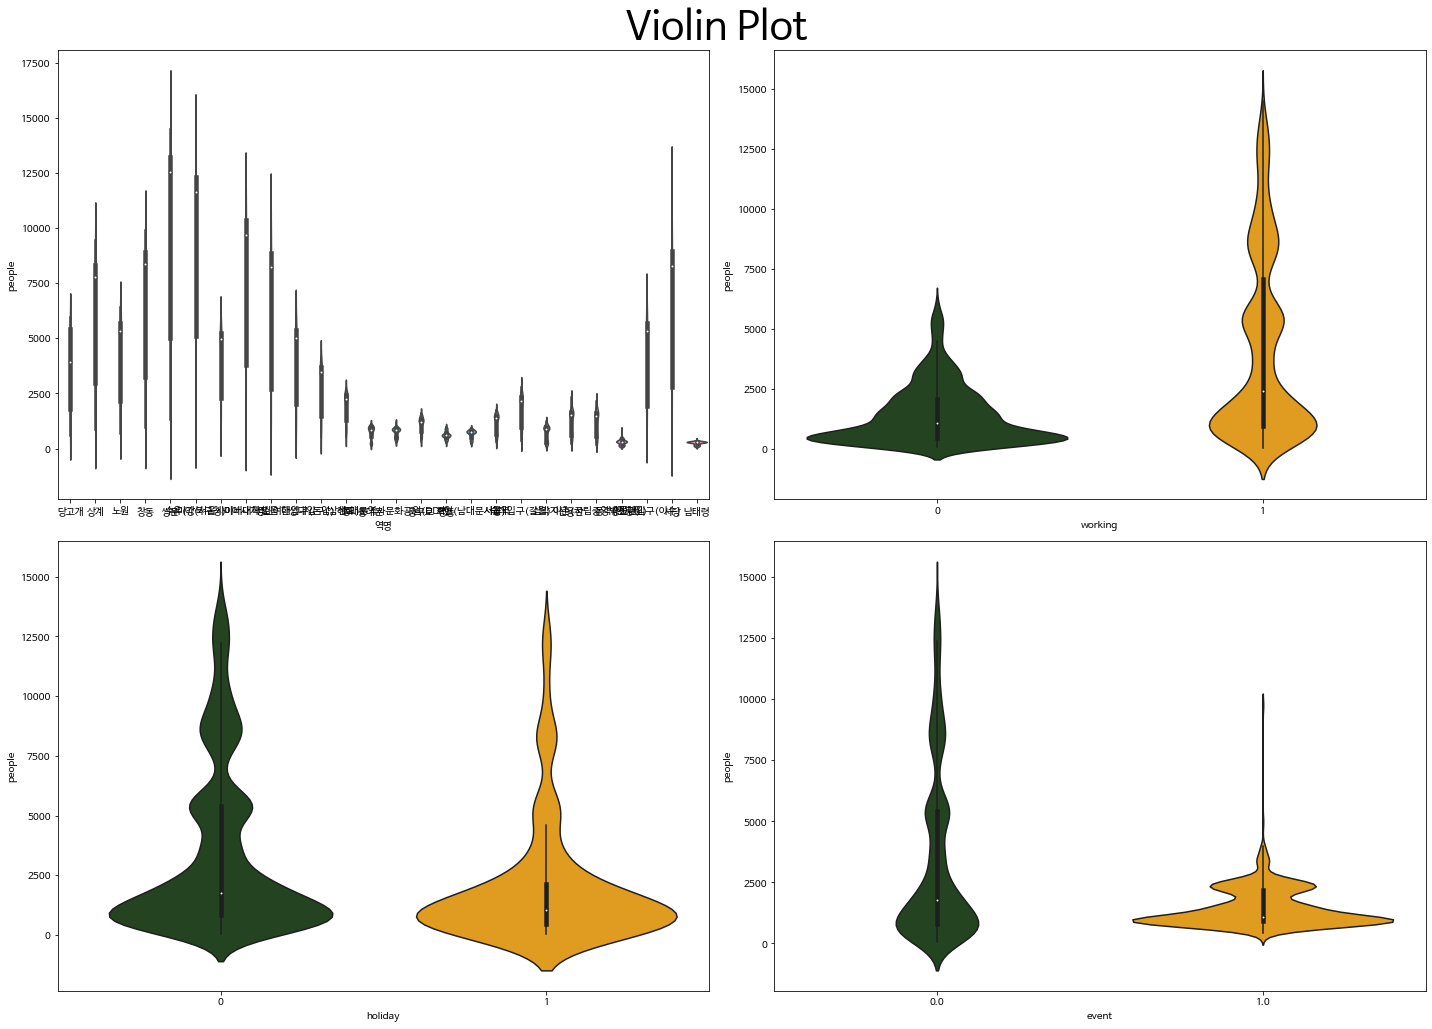

In [ ]:
# target과 카테고리형 feature의 관계

feature = categorical_feature

plt.figure(figsize=(20,15))
plt.suptitle("Violin Plot", fontsize=40)

for i in range(len(feature)):
    plt.subplot(2,2,i+1)
    plt.xlabel(feature[i])
    plt.ylabel(people)
    sns.violinplot(x= dataset[feature[i]], y= dataset[people])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
train = dataset.copy()

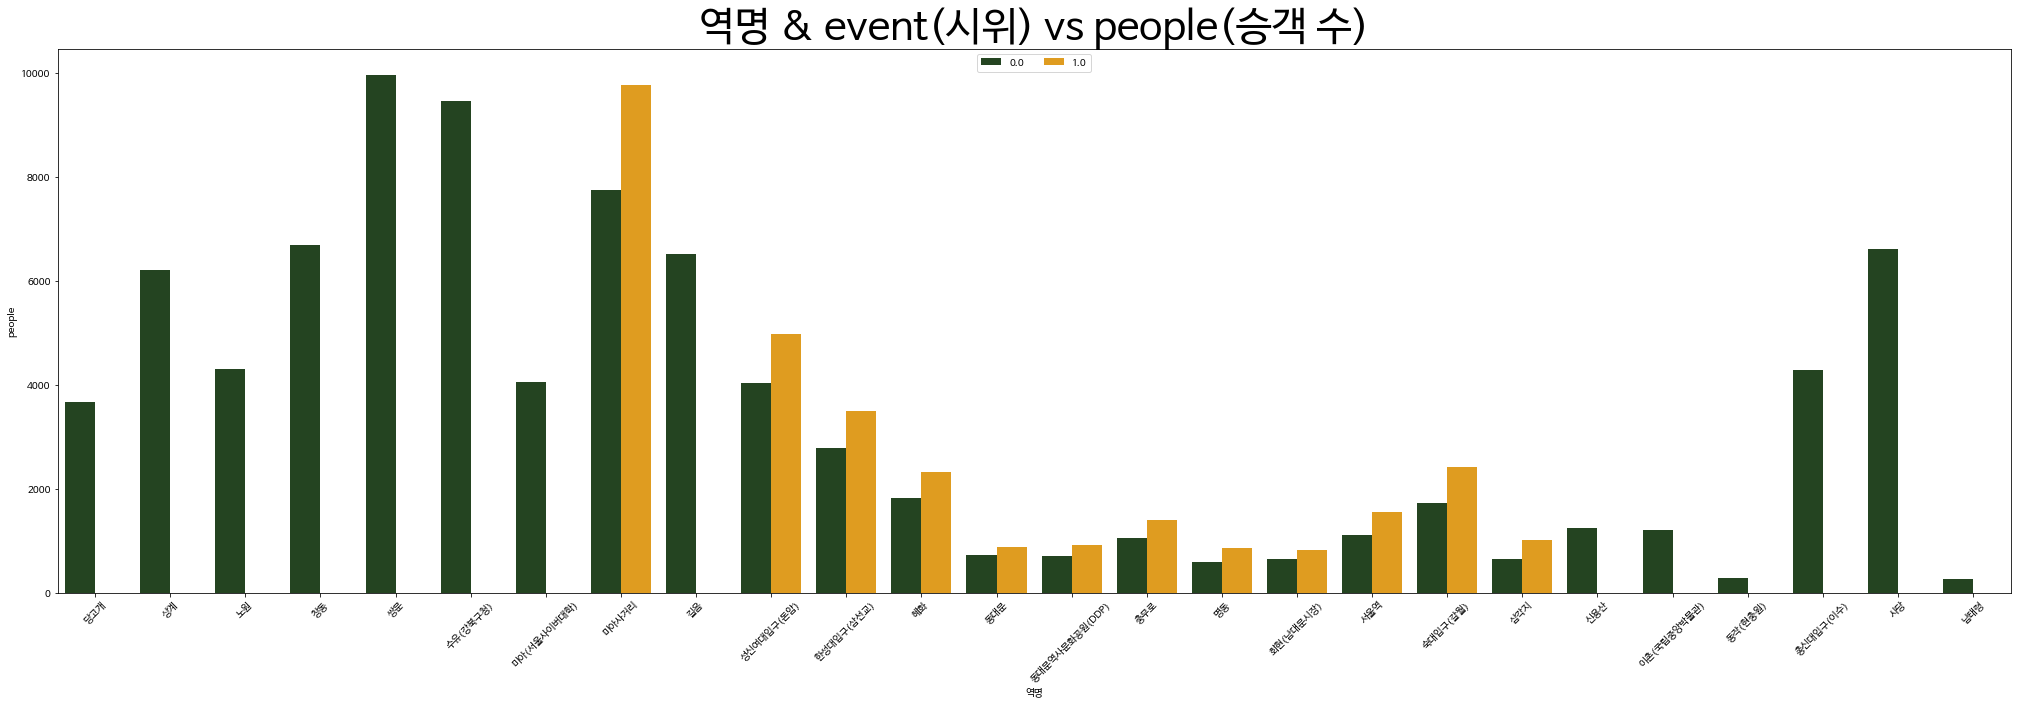

In [ ]:
plt.figure(figsize = (35,10))
sns.barplot(x = "역명", y = "people", hue = "event", data = train, ci = None)
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5,1))
plt.title("역명 & event(시위) vs people(승객 수)", fontsize = 40)
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


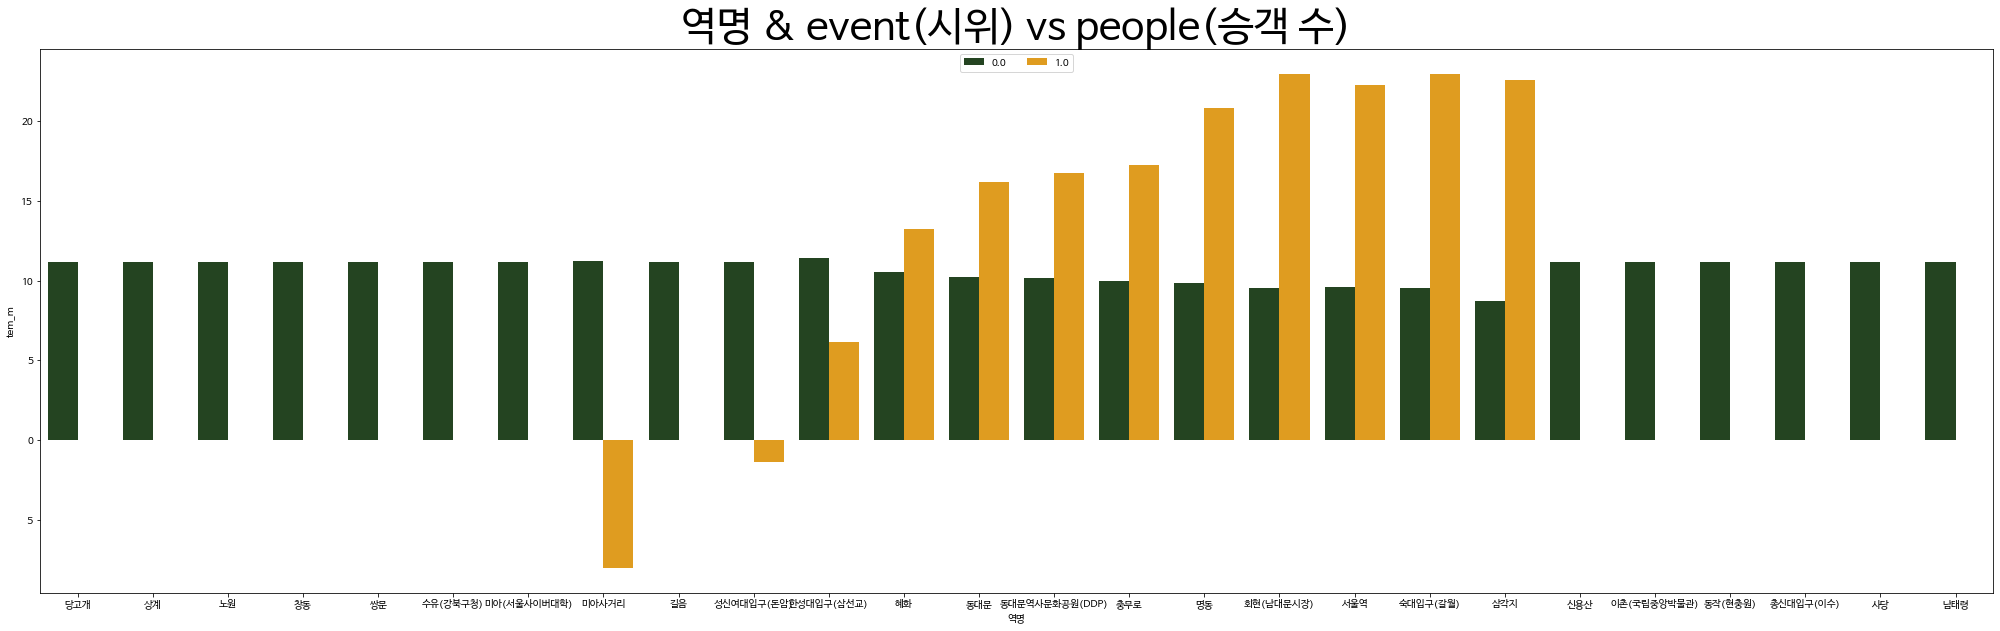

In [ ]:
plt.figure(figsize = (35,10))
sns.barplot(x = "역명", y = "tem_m", hue = "event", data = train, ci = None)
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1))
plt.title("역명 & event(시위) vs people(승객 수)", fontsize = 40)
plt.show()

# 모델링

In [ ]:
df = pd.get_dummies(dataset, columns=['역명'])

In [ ]:
X_cols = df.drop('people', axis = 1).columns
df['event'] = df['event'].astype('int8')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9769 entries, 0 to 9768
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tem_m              9769 non-null   float64
 1   rain_m             9769 non-null   float64
 2   wind_m             9769 non-null   float64
 3   humid_m            9769 non-null   float64
 4   working            9769 non-null   int64  
 5   people             9769 non-null   int64  
 6   holiday            9769 non-null   int64  
 7   event              9769 non-null   int8   
 8   역명_길음              9769 non-null   uint8  
 9   역명_남태령             9769 non-null   uint8  
 10  역명_노원              9769 non-null   uint8  
 11  역명_당고개             9769 non-null   uint8  
 12  역명_동대문             9769 non-null   uint8  
 13  역명_동대문역사문화공원(DDP)  9769 non-null   uint8  
 14  역명_동작(현충원)         9769 non-null   uint8  
 15  역명_명동              9769 non-null   uint8  
 16  역명_미아(서울사이버대학)     9769 

In [ ]:
# trian 과 test 0.8 비율로 분할 

from sklearn.model_selection import train_test_split

normed_train_data = df.drop('people', axis = 1).values
train_label = df['people'].values


train_data, test_data, train_labels, test_labels = train_test_split(normed_train_data, train_label, test_size=0.2, random_state=123)

### 데이터 정규화

In [ ]:
scaler = MinMaxScaler()   

normed_train_data = scaler.fit_transform(train_data)
normed_test_data= scaler.transform(test_data)

### 데이터 분할

In [ ]:
## train데이터에서 train 과 valid 데이터로 분할 0.8

from sklearn.model_selection import train_test_split
normed_train_data, normed_valid_data, train_labels, valid_labels = train_test_split(normed_train_data,train_labels,test_size=0.2, random_state=123)
print('훈련 데이터: ', normed_train_data.shape)
print('검증 데이터:', normed_valid_data.shape)

훈련 데이터:  (6252, 33)
검증 데이터: (1563, 33)


# dnn
- "숨겨진" 비선형 레이어를 포함하도록 모델이 확장된다는 점을 제외하고는 기본적으로 동일
-여기서 "숨겨진"이라는 말은 입력 또는 출력에 직접 연결되지 않음을 의미

In [ ]:
normed_train_data

array([[0.161, 0.   , 0.61 , ..., 0.   , 0.   , 0.   ],
       [0.501, 0.   , 0.154, ..., 0.   , 0.   , 0.   ],
       [0.57 , 0.   , 0.176, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.294, 0.   , 0.209, ..., 0.   , 0.   , 0.   ],
       [0.332, 0.   , 0.258, ..., 0.   , 0.   , 0.   ],
       [0.647, 0.   , 0.225, ..., 0.   , 0.   , 0.   ]])

In [ ]:
# rmse 함수화

def rmse_loss(y_true, y_pred):
  err = y_true - y_pred
  loss = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(err)))

  return loss


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(normed_train_data[0])]),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss = 'mae',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

  return model

In [ ]:
dnn_model = build_model()
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2176      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# from keras.callbacks import ModelCheckpoint

# checkpoint_filepath = "/content/drive/MyDrive/checkpoints/best_dnn.ckpt"
# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='mae',
#     mode='max',
#     save_best_only=True,
#     verbose=1)


In [ ]:
%%time
history = dnn_model.fit(
    normed_train_data, train_labels,
    validation_data = (normed_valid_data, valid_labels),
    verbose=0, epochs=100)

CPU times: user 42.8 s, sys: 2.87 s, total: 45.6 s
Wall time: 41.8 s


In [ ]:
y_predict = dnn_model.predict(normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 1ms/step
예측값: [[ 5253.961]
 [ 5265.24 ]
 [ 5296.17 ]
 ...
 [13067.981]
 [12114.858]
 [ 8633.277]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test, y_predict):
   return np.sqrt(mean_squared_error(y_test, y_predict))
print("RMSE : ", RMSE(test_labels, y_predict))

RMSE :  912.1291001069796


In [ ]:
# R2 구하기
from sklearn.metrics import r2_score
r2_y_predict = r2_score(test_labels, y_predict)
print("R2 : ", r2_y_predict)

R2 :  0.9312633857913718


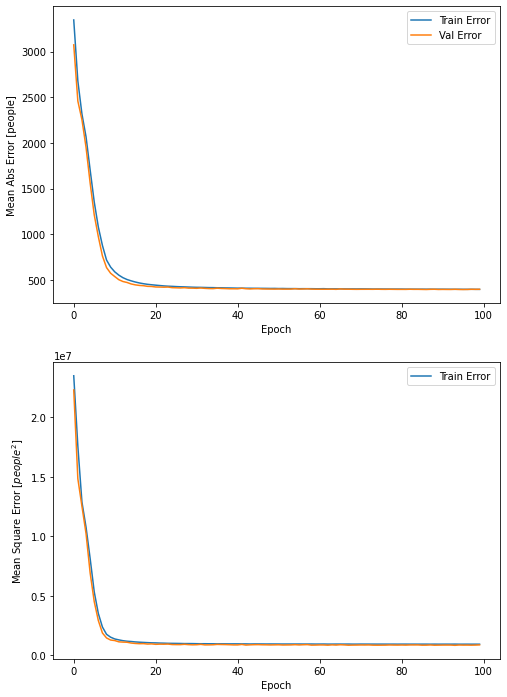

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [people]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$people^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'])

  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
loss, mae, mse = dnn_model.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차: {:5.2f} people".format(mae))

62/62 - 0s - loss: 380.2920 - mae: 380.2920 - mse: 831979.4375 - 100ms/epoch - 2ms/step
테스트 세트의 평균 절대 오차: 380.29 people


62/62 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Predictions [people]')

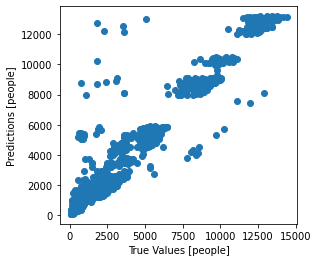

In [ ]:
# 예측 
test_predictions = dnn_model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [people]')
plt.ylabel('Predictions [people]')


In [ ]:
test_results= {}

test_results['dnn'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T

,rmse,mae,mse
dnn,912.1291,380.292046,831979.495262


# dnn_dropout

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def build_model_d():
  model_d = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(normed_train_data[0])]),
      Dropout(0.3),
      layers.Dense(64, activation='relu'),
      Dropout(0.3),
      layers.Dense(1)
  ])

  model_d.compile(loss = 'mae',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

  return model_d

In [ ]:
dnn_model_d = build_model_d()
dnn_model_d.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_183 (Dense)           (None, 64)                2176      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_184 (Dense)           (None, 64)                4160      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_185 (Dense)           (None, 1)                 65        
                                                                 
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = dnn_model_d.fit(
    normed_train_data, train_labels,
    validation_data = (normed_valid_data, valid_labels),
    verbose=0, epochs=100)

CPU times: user 1min 9s, sys: 6.17 s, total: 1min 15s
Wall time: 1min 22s


In [ ]:
y_predict = dnn_model_d.predict(normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 1ms/step
예측값: [[ 4985.002]
 [ 4820.156]
 [ 4812.777]
 ...
 [12273.201]
 [11607.485]
 [ 8490.24 ]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
# R2 구하기
from sklearn.metrics import r2_score
r2_y_predict = r2_score(test_labels, y_predict)
print("R2 : ", r2_y_predict)

loss, mae, mse = dnn_model_d.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차: {:5.2f} people".format(mae))

R2 :  0.9334503956012189
62/62 - 0s - loss: 404.8480 - mae: 404.8480 - mse: 805508.1250 - 129ms/epoch - 2ms/step
테스트 세트의 평균 절대 오차: 404.85 people


62/62 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Predictions [people]')

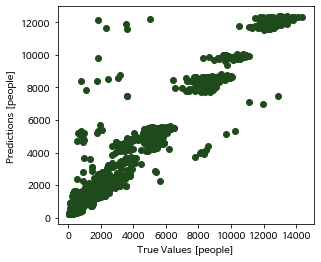

In [ ]:
# 예측 
test_predictions = dnn_model_d.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [people]')
plt.ylabel('Predictions [people]')

In [ ]:
test_results['dnn_dropout'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T

,rmse,mae,mse
dnn,908.752035,382.860854,825830.261672
dnn_dropout,897.501085,404.847982,805508.198433


#dnn_BatchNormalization

In [ ]:
def build_model_BatchNormalization():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(normed_train_data[0])]),
      BatchNormalization(),
      layers.Dense(64, activation='relu'),
      BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss = 'mae',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

  return model

dnn_model_b = build_model_BatchNormalization()
dnn_model_b.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 64)                2176      
                                                                 
 batch_normalization_31 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_187 (Dense)           (None, 64)                4160      
                                                                 
 batch_normalization_32 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_188 (Dense)           (None, 1)                 65        
                                                                 
Total params: 6,913
Trainable params: 6,657
Non-train

In [ ]:
%%time
history = dnn_model_b.fit(
    normed_train_data, train_labels,
    validation_data = (normed_valid_data, valid_labels),
    verbose=0, epochs=100)

CPU times: user 1min 35s, sys: 8.55 s, total: 1min 43s
Wall time: 1min 17s


In [ ]:
y_predict = dnn_model_b.predict(normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 2ms/step
예측값: [[ 5015.943]
 [ 4586.031]
 [ 4810.906]
 ...
 [12441.425]
 [11304.206]
 [ 8409.333]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
# R2 구하기
from sklearn.metrics import r2_score
r2_y_predict = r2_score(test_labels, y_predict)
print("R2 : ", r2_y_predict)

loss, mae, mse = dnn_model_b.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차: {:5.2f} people".format(mae))

R2 :  0.9304668316468709
62/62 - 0s - loss: 380.3099 - mae: 380.3099 - mse: 841620.8125 - 131ms/epoch - 2ms/step
테스트 세트의 평균 절대 오차: 380.31 people


62/62 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Predictions [people]')

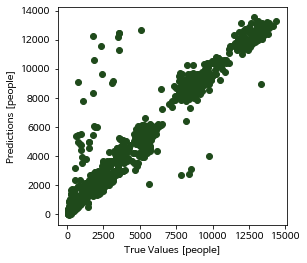

In [ ]:
# 예측 
test_predictions = dnn_model_b.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [people]')
plt.ylabel('Predictions [people]')

In [ ]:
test_results['dnn_batchNormalization'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T

,rmse,mae,mse
dnn,908.752035,382.860854,825830.261672
dnn_dropout,897.501085,404.847982,805508.198433
dnn_batchNormalization,917.398980,380.309921,841620.888320


# dnn_dropout_BatchNormalization

In [ ]:
def build_model_drop_BatchNormalization():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(normed_train_data[0])]),
      Dropout(0.3),
      BatchNormalization(),
      layers.Dense(64, activation='relu'),
      Dropout(0.3),
      BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss = 'mae',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

  return model

dnn_model_db = build_model_drop_BatchNormalization()
dnn_model_db.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 64)                2176      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_33 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_190 (Dense)           (None, 64)                4160      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_34 (Bat  (None, 64)               256       
 chNormalization)                                    

In [ ]:
%%time
history = dnn_model_db.fit(
    normed_train_data, train_labels,
    validation_data = (normed_valid_data, valid_labels),
    verbose=0, epochs=100)

CPU times: user 1min 38s, sys: 8.34 s, total: 1min 47s
Wall time: 2min 22s


In [ ]:
y_predict = dnn_model_db.predict(normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 2ms/step
예측값: [[ 5160.863]
 [ 4493.701]
 [ 4622.662]
 ...
 [12642.218]
 [11950.104]
 [ 8186.299]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
# R2 구하기
from sklearn.metrics import r2_score
r2_y_predict = r2_score(test_labels, y_predict)
print("R2 : ", r2_y_predict)

loss, mae, mse = dnn_model_db.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차: {:5.2f} people".format(mae))

R2 :  0.9360381417340293
62/62 - 0s - loss: 406.7532 - mae: 406.7532 - mse: 774186.4375 - 129ms/epoch - 2ms/step
테스트 세트의 평균 절대 오차: 406.75 people


62/62 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Predictions [people]')

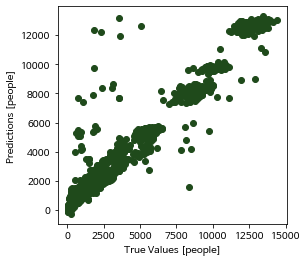

In [ ]:
# 예측 
test_predictions = dnn_model_db.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [people]')
plt.ylabel('Predictions [people]')

In [ ]:
test_results['dnn_dropout_batchNormalization'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T

,rmse,mae,mse
dnn,908.752035,382.860854,825830.261672
dnn_dropout,897.501085,404.847982,805508.198433
dnn_batchNormalization,917.398980,380.309921,841620.888320
dnn_dropout_batchNormalization,879.878650,406.753219,774186.438608


# dnn_ensemble

In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# def build_model_dnn_sdesemble():
#   model_dnn_ensemble = keras.Sequential([
#       layers.Dense(64, activation='relu', input_shape=[len(normed_train_data[0])]),
#       layers.Dense(64, activation='relu'),
#       layers.Dense(1)
#   ])

#   model_dnn_ensemble.compile(loss = 'mae',
#                 optimizer=tf.keras.optimizers.Adam(0.001),
#                 metrics=['mae', 'mse'])

#   return model_dnn_ensemble

In [ ]:
# from keras.callbacks import ModelCheckpoint


# es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
# checkpoint_filepath = '/content/drive/MyDrive/models/weights.{val_loss:.3f}--'
# cp=keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath+str(i)+'.h5',
#     save_weights_only=True,
#     monitor='val_loss',
#     save_best_only=True)

In [ ]:
# %%time
# history = model_dnn_ensemble.fit(
#     normed_train_data, train_labels,
#     validation_data = (normed_valid_data, valid_labels),
#     callbacks=[es,cp],
#     verbose=1, epochs=100)

In [ ]:
from keras.layers import Dense,Dropout,BatchNormalization,Add,Input,Activation,Concatenate,Average

In [ ]:
x_train_val = np.concatenate([normed_valid_data, normed_train_data])
y_train_val = np.concatenate([valid_labels, train_labels])

x_train_val=np.array(x_train_val)
y_train_val=np.array(y_train_val)
x_train_val.shape

(7815, 33)

In [ ]:
# get the model
def fit_model(x_train,x_val,y_train,y_val,i):
  model = Sequential()
  #model.add(BatchNormalization())
  model.add(Dense(64, input_dim=33, activation='relu'))
  #model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  #model.add(BatchNormalization())
  model.add(Dense(1))

  model.compile(loss='mae',optimizer= tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

  es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='/content/drive/MyDrive/models/weights.'
  cp=keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath+str(i)+'.h5',
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=100,
                  validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=32, verbose=0
                  )
  
  return model

- monitor='val_loss', patience=20이라고 지정하면 검증셋의 오차가 20번 이상 낮아지지 않을 경우 학습을 종료

In [ ]:
from sklearn.model_selection import KFold

kf=KFold(5,shuffle=True)
i=0
for train_index,val_index in kf.split(x_train_val):
  i+=1
  x_train,x_val=x_train_val[train_index],x_train_val[val_index]
  y_train,y_val=y_train_val[train_index],y_train_val[val_index]
  model=fit_model(x_train,x_val,y_train,y_val,i)
  print('finish {} model'.format(i))

finish 1 model
finish 2 model
finish 3 model
finish 4 model
finish 5 model


In [ ]:
for i in range(1,6):
  filename='/content/drive/MyDrive/models/weights.'+str(i)+'.h5'
  model=load_model(filename)
  model.evaluate(x_val,y_val)

49/49 [==============================] - 0s 2ms/step - loss: 398.3239 - mae: 398.3239 - mse: 925565.8750


In [ ]:
from keras import Model

In [ ]:
def load_all_models(n_models):
  all_models=list()
  for i in range(n_models):
    filename='/content/drive/MyDrive/models/weights.'+str(i+1)+'.h5'
    model=load_model(filename)
    all_models.append(model)

    print('>loaded %s' %filename)
  return all_models
  
def define_stacked_model(members):
  # update all layers in all models to not be trainiable
  for i in range(len(members)):
    model=members[i]
    for layer in model.layers:
      layer.trainable=False
      # rename to avoid 'unique layer name' issue
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
  
  # define multi-handed input
  ensemble_visible=[model.input for model in members]
  ensemble_outputs=[model.output for model in members]

  y=Average()(ensemble_outputs)

  model= Model(inputs=ensemble_visible,outputs=y,name='ensemble')

  keras.utils.plot_model(model,show_shapes=True,to_file='/content/drive/MyDrive/model_graph.jpg')

  model.compile(loss='mae',optimizer='adam',
                metrics=['mae', 'mse'])
  return model

def fit_stacked_model(model,trainX,valX,trainY,valY):
  x_train=[trainX for _ in range(len(model.input))]
  x_val=[valX for _ in range(len(model.input))]
  y_train=trainY
  y_val=valY

  es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='/content/drive/MyDrive/ensemble_model.h5'
  cp=keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=1,validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=32)

def evaluate_stacked_model(model,inputX,y_val):
  x_val=[inputX for _ in range(len(model.input))]
  return model.evaluate(x_val,y_val)

def predict_stacked_model(model,inputX):
  x_test=[inputX for _ in range(len(model.input))]
  return model.predict(x_test)

In [ ]:
n_members=5
members=load_all_models(n_members)
print('Loaded %d members' %len(members))

stacked_model=define_stacked_model(members)
fit_stacked_model(stacked_model,x_train,x_val,y_train,y_val)

>loaded /content/drive/MyDrive/models/weights.1.h5
>loaded /content/drive/MyDrive/models/weights.2.h5
>loaded /content/drive/MyDrive/models/weights.3.h5
>loaded /content/drive/MyDrive/models/weights.4.h5
>loaded /content/drive/MyDrive/models/weights.5.h5
Loaded 5 members
196/196 [==============================] - 2s 8ms/step - loss: 403.4760 - mae: 403.4760 - mse: 971352.3125 - val_loss: 387.7277 - val_mae: 387.7277 - val_mse: 841459.0000


In [ ]:
evaluate_stacked_model(stacked_model,normed_test_data,test_labels)

62/62 [==============================] - 0s 3ms/step - loss: 387.4068 - mae: 387.4068 - mse: 853853.8750


[387.4067687988281, 387.4067687988281, 853853.875]

In [ ]:
y_predict=predict_stacked_model(stacked_model,normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 2ms/step
예측값: [[ 5190.337]
 [ 4833.373]
 [ 4839.535]
 ...
 [13026.356]
 [11962.44 ]
 [ 8649.273]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
test_results['dnn_ensemble'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T

,rmse,mae,mse
dnn,908.752035,382.860854,825830.261672
dnn_dropout,897.501085,404.847982,805508.198433
dnn_batchNormalization,917.398980,380.309921,841620.888320
dnn_dropout_batchNormalization,879.878650,406.753219,774186.438608
dnn_ensemble,924.042242,387.406793,853854.064584


# dnn_ensemble_dropout

In [ ]:
# x_train_val = np.concatenate([normed_valid_data, normed_train_data])
# y_train_val = np.concatenate([valid_labels, train_labels])

# x_train_val=np.array(x_train_val)
# y_train_val=np.array(y_train_val)
# x_train_val.shape

(7815, 33)

In [ ]:
# get the model
def fit_model(x_train,x_val,y_train,y_val,i):
  model = Sequential()
  model.add(Dense(64, input_dim=33, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1))

  model.compile(loss='mae',optimizer='adam',
                metrics=['mae', 'mse'])

  es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='/content/drive/MyDrive/models_d/weights.'
  cp=keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath+str(i)+'.h5',
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=100,
                  validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=32, verbose=0
                  )
  
  return model

In [ ]:
from sklearn.model_selection import KFold
kf=KFold(5,shuffle=True)
i=0
for train_index,val_index in kf.split(x_train_val):
  i+=1
  x_train,x_val=x_train_val[train_index],x_train_val[val_index]
  y_train,y_val=y_train_val[train_index],y_train_val[val_index]
  model=fit_model(x_train,x_val,y_train,y_val,i)
  print('finish {} model'.format(i))

finish 1 model
finish 2 model
finish 3 model
finish 4 model
finish 5 model


In [ ]:
for i in range(1,6):
  filename='/content/drive/MyDrive/models_d/weights.'+str(i)+'.h5'
  model=load_model(filename)
  model.evaluate(x_val,y_val)

49/49 [==============================] - 1s 5ms/step - loss: 431.9910 - mae: 431.9910 - mse: 956236.2500


In [ ]:
from keras import Model

In [ ]:
def load_all_models(n_models):
  all_models=list()
  for i in range(n_models):
    filename='/content/drive/MyDrive/models_d/weights.'+str(i+1)+'.h5'
    model=load_model(filename)
    all_models.append(model)

    print('>loaded %s' %filename)
  return all_models
  
def define_stacked_model(members):
  # update all layers in all models to not be trainiable
  for i in range(len(members)):
    model=members[i]
    for layer in model.layers:
      layer.trainable=False
      # rename to avoid 'unique layer name' issue
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
  
  # define multi-handed input
  ensemble_visible=[model.input for model in members]
  ensemble_outputs=[model.output for model in members]

  y=Average()(ensemble_outputs)

  model= Model(inputs=ensemble_visible,outputs=y,name='ensemble')

  keras.utils.plot_model(model,show_shapes=True,to_file='/content/drive/MyDrive/model_graph.jpg')

  model.compile(loss='mae',optimizer='adam',
                metrics=['mae', 'mse'])
  return model

def fit_stacked_model(model,trainX,valX,trainY,valY):
  x_train=[trainX for _ in range(len(model.input))]
  x_val=[valX for _ in range(len(model.input))]
  y_train=trainY
  y_val=valY

  es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='/content/drive/MyDrive/ensemble_model.h5'
  cp=keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=1,validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=32)

def evaluate_stacked_model(model,inputX,y_val):
  x_val=[inputX for _ in range(len(model.input))]
  return model.evaluate(x_val,y_val)

def predict_stacked_model(model,inputX):
  x_test=[inputX for _ in range(len(model.input))]
  return model.predict(x_test)

In [ ]:
n_members=5
members=load_all_models(n_members)
print('Loaded %d members' %len(members))

stacked_model=define_stacked_model(members)
fit_stacked_model(stacked_model,x_train,x_val,y_train,y_val)

>loaded /content/drive/MyDrive/models_d/weights.1.h5
>loaded /content/drive/MyDrive/models_d/weights.2.h5
>loaded /content/drive/MyDrive/models_d/weights.3.h5
>loaded /content/drive/MyDrive/models_d/weights.4.h5
>loaded /content/drive/MyDrive/models_d/weights.5.h5
Loaded 5 members
196/196 [==============================] - 3s 9ms/step - loss: 461.8239 - mae: 461.8239 - mse: 1025181.3750 - val_loss: 422.2829 - val_mae: 422.2829 - val_mse: 928900.3125


In [ ]:
evaluate_stacked_model(stacked_model,normed_test_data,test_labels)

62/62 [==============================] - 0s 3ms/step - loss: 395.4287 - mae: 395.4287 - mse: 834975.0625


[395.4286804199219, 395.4286804199219, 834975.0625]

In [ ]:
y_predict=predict_stacked_model(stacked_model,normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 2ms/step
예측값: [[ 5149.966]
 [ 4880.187]
 [ 4841.929]
 ...
 [12547.616]
 [11830.6  ]
 [ 8622.913]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
test_results['dnn_ensemble_dropout'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T

,rmse,mae,mse
dnn,908.752035,382.860854,825830.261672
dnn_dropout,897.501085,404.847982,805508.198433
dnn_batchNormalization,917.398980,380.309921,841620.888320
dnn_dropout_batchNormalization,879.878650,406.753219,774186.438608
dnn_ensemble,924.042242,387.406793,853854.064584
dnn_ensemble_dropout,913.769799,395.428632,834975.246348


# dnn_ensemble_batchnormalization

In [ ]:
x_train_val = np.concatenate([normed_valid_data, normed_train_data])
y_train_val = np.concatenate([valid_labels, train_labels])

x_train_val=np.array(x_train_val)
y_train_val=np.array(y_train_val)
x_train_val.shape

(7815, 33)

In [ ]:
# get the model
def fit_model(x_train,x_val,y_train,y_val,i):
  model = Sequential()
  model.add(Dense(64, input_dim=33, kernel_initializer='he_uniform', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1))

  model.compile(loss='mae',optimizer='adam',
                metrics=['mae', 'mse'])

  es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='/content/drive/MyDrive/models_b/weights.'
  cp=keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath+str(i)+'.h5',
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=100,
                  validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=32,verbose=0)
  return model
  

from sklearn.model_selection import KFold
kf=KFold(5,shuffle=True)
i=0
for train_index,val_index in kf.split(x_train_val):
  i+=1
  x_train,x_val=x_train_val[train_index],x_train_val[val_index]
  y_train,y_val=y_train_val[train_index],y_train_val[val_index]
  model=fit_model(x_train,x_val,y_train,y_val,i)
  print('finish {} model'.format(i))

finish 1 model
finish 2 model
finish 3 model
finish 4 model
finish 5 model


In [ ]:
for i in range(1,6):
  filename='/content/drive/MyDrive/models_b/weights.'+str(i)+'.h5'
  model=load_model(filename)
  model.evaluate(x_val,y_val)

49/49 [==============================] - 0s 2ms/step - loss: 392.3165 - mae: 392.3165 - mse: 705482.7500


In [ ]:
def load_all_models(n_models):
  all_models=list()
  for i in range(n_models):
    filename='/content/drive/MyDrive/models_b/weights.'+str(i+1)+'.h5'
    model=load_model(filename)
    all_models.append(model)

    print('>loaded %s' %filename)
  return all_models
  
def define_stacked_model(members):
  # update all layers in all models to not be trainiable
  for i in range(len(members)):
    model=members[i]
    for layer in model.layers:
      layer.trainable=False
      # rename to avoid 'unique layer name' issue
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
  
  # define multi-handed input
  ensemble_visible=[model.input for model in members]
  ensemble_outputs=[model.output for model in members]

  y=Average()(ensemble_outputs)

  model= Model(inputs=ensemble_visible,outputs=y,name='ensemble')

  keras.utils.plot_model(model,show_shapes=True,to_file='/content/drive/MyDrive/model_graph.jpg')

  model.compile(loss='mae',optimizer='adam',
                metrics=['mae', 'mse'])
  return model

def fit_stacked_model(model,trainX,valX,trainY,valY):
  x_train=[trainX for _ in range(len(model.input))]
  x_val=[valX for _ in range(len(model.input))]
  y_train=trainY
  y_val=valY

  es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='/content/drive/MyDrive/ensemble_model.h5'
  cp=keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=1,validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=32)

def evaluate_stacked_model(model,inputX,y_val):
  x_val=[inputX for _ in range(len(model.input))]
  return model.evaluate(x_val,y_val)

def predict_stacked_model(model,inputX):
  x_test=[inputX for _ in range(len(model.input))]
  return model.predict(x_test)

In [ ]:
n_members=5
members=load_all_models(n_members)
print('Loaded %d members' %len(members))

stacked_model=define_stacked_model(members)
fit_stacked_model(stacked_model,x_train,x_val,y_train,y_val)

>loaded /content/drive/MyDrive/models_b/weights.1.h5
>loaded /content/drive/MyDrive/models_b/weights.2.h5
>loaded /content/drive/MyDrive/models_b/weights.3.h5
>loaded /content/drive/MyDrive/models_b/weights.4.h5
>loaded /content/drive/MyDrive/models_b/weights.5.h5
Loaded 5 members
196/196 [==============================] - 3s 10ms/step - loss: 365.3741 - mae: 365.3741 - mse: 843534.5625 - val_loss: 351.2016 - val_mae: 351.2016 - val_mse: 607527.0000


In [ ]:
evaluate_stacked_model(stacked_model,normed_test_data,test_labels)

62/62 [==============================] - 0s 4ms/step - loss: 363.2438 - mae: 363.2438 - mse: 750661.9375


[363.24383544921875, 363.24383544921875, 750661.9375]

In [ ]:
y_predict=predict_stacked_model(stacked_model,normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 3ms/step
예측값: [[ 5175.407]
 [ 4504.167]
 [ 4596.103]
 ...
 [12762.617]
 [11787.463]
 [ 8344.757]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
test_results['dnn_ensemble_batchnormalization'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

In [ ]:
a.drop('dnn_ensemble_dropout_batchnormalization', axis = 0)

,rmse,mae,mse
dnn,908.752035,382.860854,825830.261672
dnn_dropout,897.501085,404.847982,805508.198433
dnn_batchNormalization,917.398980,380.309921,841620.888320
dnn_dropout_batchNormalization,879.878650,406.753219,774186.438608
dnn_ensemble,924.042242,387.406793,853854.064584
dnn_ensemble_dropout,913.769799,395.428632,834975.246348
dnn_ensemble_batchnormalization,866.407398,363.243824,750661.779283


# dnn_ensemble_dropout_batchnormalization

In [ ]:
x_train_val = np.concatenate([normed_valid_data, normed_train_data])
y_train_val = np.concatenate([valid_labels, train_labels])

x_train_val=np.array(x_train_val)
y_train_val=np.array(y_train_val)
x_train_val.shape

(7815, 33)

In [ ]:
# get the model
def fit_model(x_train,x_val,y_train,y_val,i):
  model = Sequential()
  model.add(Dense(64, input_dim=33, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(1))

  model.compile(loss='mae',optimizer='adam',
                metrics=['mae', 'mse'])

  es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='/content/drive/MyDrive/models_db/weights.'
  cp=keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath+str(i)+'.h5',
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=100,
                  validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=32, verbose=0)
  return model
  

from sklearn.model_selection import KFold
kf=KFold(5,shuffle=True)
i=0
for train_index,val_index in kf.split(x_train_val):
  i+=1
  x_train,x_val=x_train_val[train_index],x_train_val[val_index]
  y_train,y_val=y_train_val[train_index],y_train_val[val_index]
  model=fit_model(x_train,x_val,y_train,y_val,i)
  print('finish {} model'.format(i))

finish 1 model
finish 2 model
finish 3 model
finish 4 model
finish 5 model


In [ ]:
for i in range(1,6):
  filename='/content/drive/MyDrive/models_db/weights.'+str(i)+'.h5'
  model=load_model(filename)
  model.evaluate(x_val,y_val)

49/49 [==============================] - 0s 3ms/step - loss: 393.9458 - mae: 393.9458 - mse: 769493.0000


In [ ]:
def load_all_models(n_models):
  all_models=list()
  for i in range(n_models):
    filename='/content/drive/MyDrive/models_db/weights.'+str(i+1)+'.h5'
    model=load_model(filename)
    all_models.append(model)

    print('>loaded %s' %filename)
  return all_models
  
def define_stacked_model(members):
  # update all layers in all models to not be trainiable
  for i in range(len(members)):
    model=members[i]
    for layer in model.layers:
      layer.trainable=False
      # rename to avoid 'unique layer name' issue
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
  
  # define multi-handed input
  ensemble_visible=[model.input for model in members]
  ensemble_outputs=[model.output for model in members]

  y=Average()(ensemble_outputs)

  model= Model(inputs=ensemble_visible,outputs=y,name='ensemble')

  keras.utils.plot_model(model,show_shapes=True,to_file='/content/drive/MyDrive/model_graph.jpg')

  model.compile(loss='mae',optimizer='adam',
                metrics=['mae', 'mse'])
  return model

def fit_stacked_model(model,trainX,valX,trainY,valY):
  x_train=[trainX for _ in range(len(model.input))]
  x_val=[valX for _ in range(len(model.input))]
  y_train=trainY
  y_val=valY

  es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='/content/drive/MyDrive/ensemble_model.h5'
  cp=keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=1,validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=32)

def evaluate_stacked_model(model,inputX,y_val):
  x_val=[inputX for _ in range(len(model.input))]
  return model.evaluate(x_val,y_val)

def predict_stacked_model(model,inputX):
  x_test=[inputX for _ in range(len(model.input))]
  return model.predict(x_test)

In [ ]:
n_members=5
members=load_all_models(n_members)
print('Loaded %d members' %len(members))

stacked_model=define_stacked_model(members)
fit_stacked_model(stacked_model,x_train,x_val,y_train,y_val)

>loaded /content/drive/MyDrive/models_db/weights.1.h5
>loaded /content/drive/MyDrive/models_db/weights.2.h5
>loaded /content/drive/MyDrive/models_db/weights.3.h5
>loaded /content/drive/MyDrive/models_db/weights.4.h5
>loaded /content/drive/MyDrive/models_db/weights.5.h5
Loaded 5 members
196/196 [==============================] - 3s 11ms/step - loss: 445.0863 - mae: 445.0863 - mse: 932779.3750 - val_loss: 374.8528 - val_mae: 374.8528 - val_mse: 701873.0625


In [ ]:
evaluate_stacked_model(stacked_model,normed_test_data,test_labels)

62/62 [==============================] - 0s 4ms/step - loss: 378.8564 - mae: 378.8564 - mse: 767782.3125


[378.8563537597656, 378.8563537597656, 767782.3125]

In [ ]:
y_predict=predict_stacked_model(stacked_model,normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 3ms/step
예측값: [[ 5187.207]
 [ 4305.806]
 [ 4486.927]
 ...
 [13312.338]
 [11886.405]
 [ 8446.229]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
test_results['dnn_ensemble_dropout_batchnormalization'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T

,rmse,mae,mse
dnn,908.752035,382.860854,825830.261672
dnn_dropout,897.501085,404.847982,805508.198433
dnn_batchNormalization,917.398980,380.309921,841620.888320
dnn_dropout_batchNormalization,879.878650,406.753219,774186.438608
dnn_ensemble,924.042242,387.406793,853854.064584
dnn_ensemble_dropout,913.769799,395.428632,834975.246348
dnn_ensemble_dropout_batchnormalization,876.231952,378.856361,767782.434147
dnn_ensemble_batchnormalization,866.407398,363.243824,750661.779283


# linear (sklearn - 통계모형형 **이용**)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
lr = LinearRegression()
lr.fit(normed_train_data, train_labels)

LinearRegression()

In [ ]:
print("회귀식의 y절편 (b)", lr.intercept_)
print("회귀식의 기울기 (a)", lr.coef_)

회귀식의 y절편 (b) -1386624537527510.8
회귀식의 기울기 (a) [ 5.254e+02 -6.962e+02  2.444e+02 -1.685e+02  2.806e+03 -1.151e+03
 -6.926e+02  1.387e+15  1.387e+15  1.387e+15  1.387e+15  1.387e+15
  1.387e+15  1.387e+15  1.387e+15  1.387e+15  1.387e+15  1.387e+15
  1.387e+15  1.387e+15  1.387e+15  1.387e+15  1.387e+15  1.387e+15
  1.387e+15  1.387e+15  1.387e+15  1.387e+15  1.387e+15  1.387e+15
  1.387e+15  1.387e+15  1.387e+15]


In [ ]:
import seaborn as sns

pred1= lr.predict(normed_test_data)
pred1[0]

5001.25

In [ ]:
test_results['linear_model_classic'] = [RMSE(test_labels, pred1), mean_absolute_error(test_labels, pred1) , mean_squared_error(test_labels, pred1) ]

test_results

{'dnn': [908.7520353056108, 382.8608537203458, 825830.26167209],
 'dnn_dropout': [897.5010854773813, 404.84798236171446, 805508.1984330775],
 'dnn_batchNormalization': [917.398979899364,
  380.30992149257366,
  841620.8883203937],
 'dnn_dropout_batchNormalization': [879.8786499329631,
  406.7532192569916,
  774186.4386078538],
 'dnn_ensemble': [924.0422417746861, 387.406792866171, 853854.0645839875],
 'dnn_ensemble_dropout': [913.7697994284607,
  395.4286322461912,
  834975.2463475293],
 'dnn_ensemble_dropout_batchnormalization': [876.231952252042,
  378.8563608765114,
  767782.4341474248],
 'dnn_ensemble_batchnormalization': [866.4073979851506,
  363.2438236361516,
  750661.7792833992],
 'linear_model_classic': [1484.4180789902525,
  1117.9085209825998,
  2203497.0332331117]}

# dnn_linear (keras를 사용한)
- 다중선형모형



In [ ]:
linear_model = tf.keras.Sequential([
     layers.Dense(64, activation='relu', input_shape=[len(normed_train_data[0])]),
     layers.Dense(units=1), 
])

In [ ]:
linear_model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

In [ ]:
%%time
history = linear_model.fit(
    normed_train_data,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_data=(normed_valid_data, valid_labels))

CPU times: user 1min 5s, sys: 5.88 s, total: 1min 11s
Wall time: 1min 22s


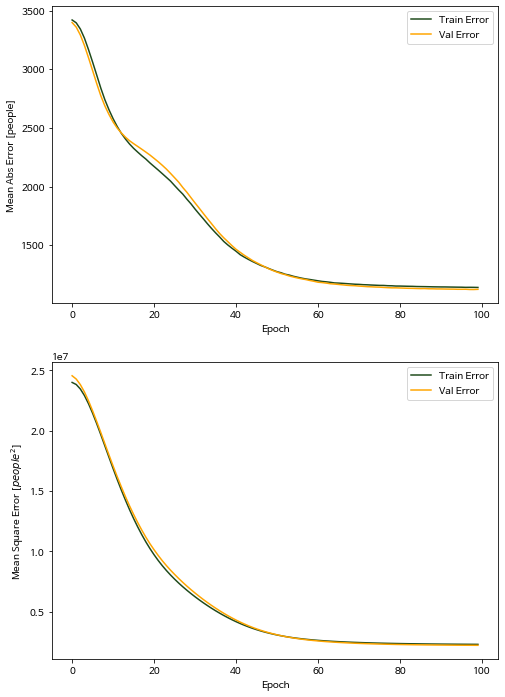

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [people]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$people^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
linear_model.predict(normed_train_data)
# linear_model.layers[1].kernel

196/196 [==============================] - 0s 1ms/step


array([[-0.233],
       [-0.198],
       [-0.314],
       ...,
       [-0.288],
       [-0.061],
       [-0.252]], dtype=float32)

In [ ]:
y_predict = linear_model.predict(normed_test_data)

print('예측값:', y_predict)
print('실제값:' , test_labels)

62/62 [==============================] - 0s 1ms/step
예측값: [[ 5213.724]
 [ 4488.553]
 [ 4619.905]
 ...
 [10483.866]
 [10181.773]
 [ 7377.   ]]
실제값: [ 4964  3923  5526 ... 12482  3600  8331]


In [ ]:
test_results['linear_model'] = [RMSE(test_labels, y_predict),mean_absolute_error(test_labels, y_predict), mean_squared_error(test_labels,y_predict)]

pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T

,rmse,mae,mse
dnn,908.752035,382.860854,8.258303e+05
dnn_dropout,897.501085,404.847982,8.055082e+05
dnn_batchNormalization,917.398980,380.309921,8.416209e+05
dnn_dropout_batchNormalization,879.878650,406.753219,7.741864e+05
dnn_ensemble,924.042242,387.406793,8.538541e+05
dnn_ensemble_dropout,913.769799,395.428632,8.349752e+05
dnn_ensemble_dropout_batchnormalization,876.231952,378.856361,7.677824e+05
dnn_ensemble_batchnormalization,866.407398,363.243824,7.506618e+05
linear_model_classic,1484.418079,1117.908521,2.203497e+06
linear_model,1485.872529,1126.424654,2.207817e+06



- 회귀 문제를 위한 기법
- (회귀 문제에 사용되는 일반적인 손실 함수)
  * 평균 제곱 오차(MSE)(tf.keras.losses.MeanSquaredError)
  * 평균 절대 오차(MAE)(tf.keras.losses.MeanAbsoluteError)
- MAE는 이상값에 덜 민감. 분류 문제에는 여러 손실 함수가 사용됨
마찬가지로 회귀에 사용되는 평가 메트릭은 분류와 다름
- 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 함
- 과대적합은 DNN 모델의 일반적인 문제이지만 이 튜토리얼에서는 문제가 되지 않았

# 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_estimators=400, random_state=123)

model_rfr.fit(normed_train_data, train_labels)

RandomForestRegressor(n_estimators=400, random_state=123)

- max_depth
  * 트리의 깊이로서, 랜덤 포레스트 트리의 루트 노드와 리프 노드 사이의 가장 긴 경로를 설정
  * 이 매개 변수를 사용하여 임의의 포리스트에있는 모든 트리가 성장할 수있는 깊이를 제한

- n_estimators
  * 랜덤 포레스트에서 결정 트리의 개수를 지정. 
  * 많이 설정할 수록 좋은 성능을 기대할 수 있지만, 계속 증가시킨다고 무조건 향상되는것은 아님
  * 또한 적을경우 과소적합이지만 증가에 따른 학습 수행시간 역시 오래걸리게 됨

- max_features
  * 전체에서 선택할 피처 개수
  * n_estimators는 클수록 트리의 깊이가 깊어지지만 max_features는 작을수록 트리가 깊어짐

In [ ]:
# 변수 중요도 확인

for x, val in zip(X_cols, model_rfr.feature_importances_):
  print(f'{x} : %.3f' % val)

tem_m : 0.025
rain_m : 0.007
wind_m : 0.019
humid_m : 0.024
working : 0.151
holiday : 0.012
event : 0.000
역명_길음 : 0.066
역명_남태령 : 0.001
역명_노원 : 0.025
역명_당고개 : 0.023
역명_동대문 : 0.000
역명_동대문역사문화공원(DDP) : 0.000
역명_동작(현충원) : 0.001
역명_명동 : 0.000
역명_미아(서울사이버대학) : 0.024
역명_미아사거리 : 0.084
역명_사당 : 0.066
역명_삼각지 : 0.000
역명_상계 : 0.063
역명_서울역 : 0.000
역명_성신여대입구(돈암) : 0.024
역명_수유(강북구청) : 0.133
역명_숙대입구(갈월) : 0.003
역명_신용산 : 0.000
역명_쌍문 : 0.142
역명_이촌(국립중앙박물관) : 0.000
역명_창동 : 0.065
역명_총신대입구(이수) : 0.025
역명_충무로 : 0.000
역명_한성대입구(삼선교) : 0.012
역명_혜화 : 0.004
역명_회현(남대문시장) : 0.000


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

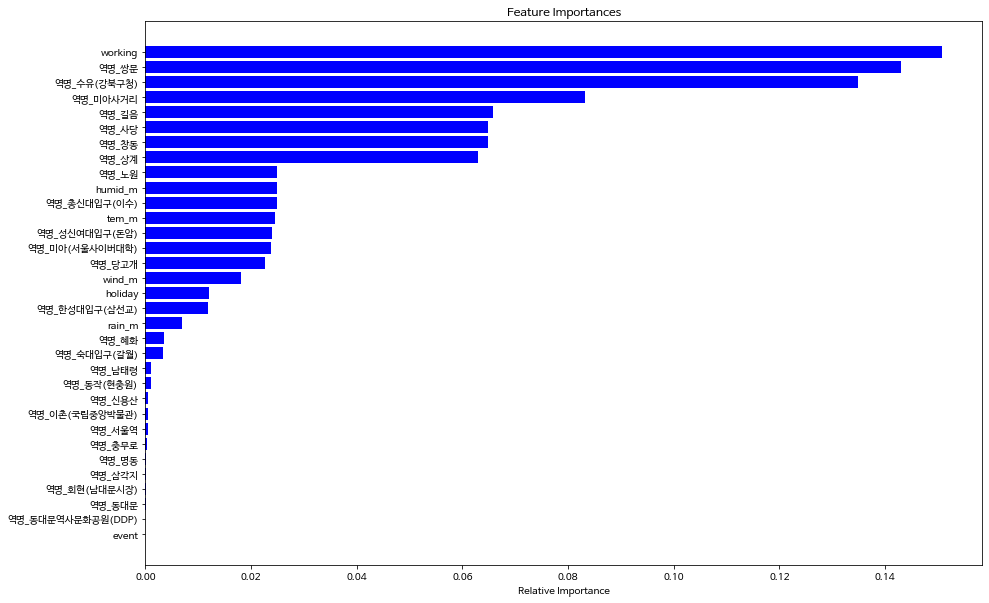

In [ ]:
importances = model_rfr.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize =(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.rc('font', family='NanumGothic')
plt.show()

- 시위데이터 중요하게 여겨지지도 않음. 당연한 게 아닐까.  왜냐면 몇 번 일어나지도 않았으니까.

In [ ]:
y_pred_rfr = model_rfr.predict(normed_test_data)

In [ ]:
print('랜덤포레스트 결과 ::  MSE: %.3f , MAE: %.3f , MAPE: %.3f' % ((mean_squared_error(test_labels, y_pred_rfr),
                                                             mean_absolute_error(test_labels, y_pred_rfr), 
                                                             mean_absolute_percentage_error(test_labels, y_pred_rfr))))

랜덤포레스트 결과 ::  MSE: 908601.913 , MAE: 410.565 , MAPE: 0.217


In [ ]:
test_results['randomforest_reg'] = [RMSE(test_labels, y_pred_rfr), mean_absolute_error(test_labels, y_pred_rfr), mean_squared_error(test_labels, y_pred_rfr) ]

pd.DataFrame(test_results, index=['rmse : loss', 'mae', 'mse']).T

,rmse : loss,mae,mse
dnn,912.129100,380.292046,8.319795e+05
randomforest_XGBOOST,1098.546367,824.865164,1.206804e+06
randomforest_reg,953.206123,410.565150,9.086019e+05


- 하이퍼파라미터 튜닝 내맘대로 돌려보면서 정함. 기본은 408,. 그냥 이걸로
* Q) 어떻게 해야  dnn보다 좋음? 

# xgboost

In [ ]:
from xgboost import XGBRegressor # 회귀트리 모델 
from xgboost import plot_importance # 중요변수 시각화 

In [ ]:
model_xg = XGBRegressor(n_estimators = 400,
                        random_state = 123)


model_xg.fit(normed_train_data, train_labels)

[01:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=400, random_state=123)

In [ ]:
# 변수 중요도 확인

for x, val in zip(X_cols, model_xg.feature_importances_):
  print(f'{x} : %.3f' % val)

tem_m : 0.002
rain_m : 0.003
wind_m : 0.003
humid_m : 0.002
working : 0.026
holiday : 0.003
event : 0.003
역명_길음 : 0.069
역명_남태령 : 0.033
역명_노원 : 0.018
역명_당고개 : 0.010
역명_동대문 : 0.019
역명_동대문역사문화공원(DDP) : 0.023
역명_동작(현충원) : 0.029
역명_명동 : 0.028
역명_미아(서울사이버대학) : 0.013
역명_미아사거리 : 0.107
역명_사당 : 0.056
역명_삼각지 : 0.025
역명_상계 : 0.058
역명_서울역 : 0.016
역명_성신여대입구(돈암) : 0.014
역명_수유(강북구청) : 0.160
역명_숙대입구(갈월) : 0.005
역명_신용산 : 0.015
역명_쌍문 : 0.115
역명_이촌(국립중앙박물관) : 0.016
역명_창동 : 0.057
역명_총신대입구(이수) : 0.017
역명_충무로 : 0.017
역명_한성대입구(삼선교) : 0.002
역명_혜화 : 0.004
역명_회현(남대문시장) : 0.030


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,206 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import matplotlib.pyplot as plt

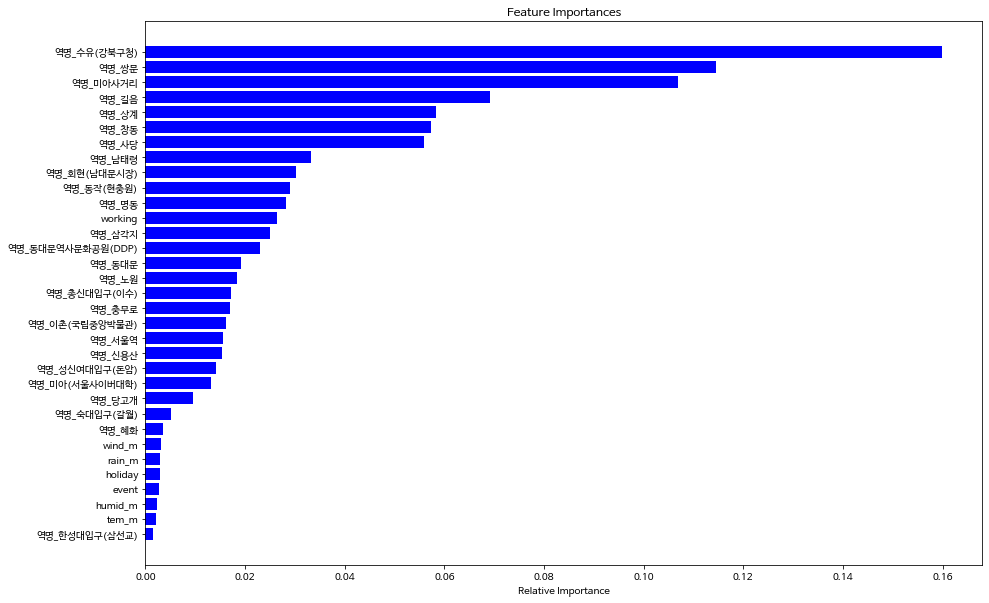

In [ ]:
importances = model_xg.feature_importances_
indices = np.argsort(importances)


plt.figure(figsize =(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.rc('font', family='NanumBarunGothic')
plt.show()

In [ ]:
y_pred_xg = model_xg.predict(normed_test_data)

In [ ]:
test_results['randomforest_XGBOOST'] = [RMSE(test_labels, y_pred_xg) , mean_absolute_error(test_labels, y_pred_xg), mean_squared_error(test_labels, y_pred_xg) ]

# 최종결과

In [ ]:
final = pd.DataFrame(test_results, index=['rmse', 'mae', 'mse']).T
final = final.reindex(['linear_model_classic','linear_model', 
       'dnn', 'dnn_dropout', 'dnn_batchNormalization',
       'dnn_dropout_batchNormalization', 'dnn_ensemble',
       'dnn_ensemble_dropout', 'dnn_ensemble_batchnormalization', 
       'dnn_ensemble_dropout_batchnormalization', 'randomforest_reg', 'randomforest_XGBOOST'])
final

,rmse,mae,mse
linear_model_classic,1484.418079,1117.908521,2.203497e+06
linear_model,1485.872529,1126.424654,2.207817e+06
dnn,908.752035,382.860854,8.258303e+05
dnn_dropout,897.501085,404.847982,8.055082e+05
dnn_batchNormalization,917.398980,380.309921,8.416209e+05
dnn_dropout_batchNormalization,879.878650,406.753219,7.741864e+05
dnn_ensemble,924.042242,387.406793,8.538541e+05
dnn_ensemble_dropout,913.769799,395.428632,8.349752e+05
dnn_ensemble_batchnormalization,866.407398,363.243824,7.506618e+05
dnn_ensemble_dropout_batchnormalization,876.231952,378.856361,7.677824e+05
